# Task: Supply estimation

The goal of this task is to estimate the quantities of the most commonly used medical supplies by COVID-19 patients

## Necessary imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
import seaborn as sb

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import datetime
from datetime import date, datetime

In [ ]:
!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 7.7 MB/s eta 0:00:00


## Data Preparation

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the cleaned main dataframe generated in the EDA stage
cleaned_main_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/cleaned_main_df') 

In [ ]:
cleaned_main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210544 entries, 0 to 210543
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                210544 non-null  int64  
 1   PATIENT_x                 210544 non-null  object 
 2   Body Weight               210544 non-null  float64
 3   Diastolic Blood Pressure  210544 non-null  float64
 4   Heart rate                210544 non-null  float64
 5   Respiratory rate          210544 non-null  float64
 6   Systolic Blood Pressure   210544 non-null  float64
 7   ORGANIZATION              210544 non-null  int64  
 8   PROVIDER                  210544 non-null  int64  
 9   PAYER                     210544 non-null  int64  
 10  DESCRIPTION               210544 non-null  int64  
 11  PAYER_COVERAGE            210544 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 19.3+ MB


In [ ]:
cleaned_main_df.head()

,Unnamed: 0,PATIENT_x,Body Weight,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,ORGANIZATION,PROVIDER,PAYER,DESCRIPTION,PAYER_COVERAGE
0,0,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,79.0,76.0,35.0,120.0,19,39,2,2,59.16
1,1,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,79.0,189.0,12.0,122.0,19,39,2,2,59.16
2,2,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,74.0,184.0,20.0,126.0,19,39,2,2,59.16
3,3,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,76.0,113.0,30.0,125.0,19,39,2,2,59.16
4,4,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,71.0,58.0,35.0,124.0,19,39,2,2,59.16


In [ ]:
# Loading the supplies dataframe
supplies_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/covid19/supplies.csv') 

In [ ]:
supplies_df.head()

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,QUANTITY
0,2020-02-19,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,b7455838-3607-47f4-aaa5-fd89abea7d29,409534002,Disposable air-purifying respirator (physical ...,2
1,2020-02-19,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,b7455838-3607-47f4-aaa5-fd89abea7d29,713779008,Nitrile examination/treatment glove non-powde...,24
2,2020-02-19,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,b7455838-3607-47f4-aaa5-fd89abea7d29,469673003,Isolation gown single-use (physical object),12
3,2020-02-19,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,b7455838-3607-47f4-aaa5-fd89abea7d29,706724001,Face shield (physical object),2
4,2020-02-19,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,b7455838-3607-47f4-aaa5-fd89abea7d29,419343004,Alcohol disinfectant (substance),1


In [ ]:
supplies_df = supplies_df.drop(columns=['CODE'])

In [ ]:
# Pivot table to create one column for each supply
supplies_pivot_df = (supplies_df.pivot_table(index=['DATE','PATIENT','ENCOUNTER'], 
                              columns=['DESCRIPTION'],
                              values='QUANTITY')
                 .reset_index()
                 .rename_axis(None, axis=1)) 

In [ ]:
supplies_pivot_df.head()

,DATE,PATIENT,ENCOUNTER,Alcohol disinfectant (substance),Antiseptic towelette (physical object),Basic endotracheal tube single-use (physical object),Carbon dioxide breath analyzer (physical object),Disposable air-purifying respirator (physical object),Endotracheal tube holder (physical object),Endotracheal tube stylet single-use (physical object),...,Laryngoscope blade single-use (physical object),Lubricant (physical object),Nasogastric tube device (physical object),Nitrile examination/treatment glove non-powdered sterile (physical object),Operating room gown single-use (physical object),Protective glasses device (physical object),Suction system (physical object),Surgical cap single-use (physical object),Syringe device (physical object),Viral filter (physical object)
0,2020-01-18,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-19,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-20,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-20,d19da9db-c5a7-468f-aadf-3c7cd5b5a8d2,a9fff9b6-5eb2-4d63-af14-282effd04648,1.0,8.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-21,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
supplies_pivot_df.isna().sum()

DATE                                                                                 0
PATIENT                                                                              0
ENCOUNTER                                                                            0
Alcohol disinfectant (substance)                                                     0
Antiseptic towelette (physical object)                                               0
Basic endotracheal tube  single-use (physical object)                           215934
Carbon dioxide breath analyzer (physical object)                                215934
Disposable air-purifying respirator (physical object)                                0
Endotracheal tube holder (physical object)                                      215934
Endotracheal tube stylet  single-use (physical object)                          215934
Face shield (physical object)                                                        0
Human plasma  blood product (product)      

From the above number of NULLS, we can assume that the common supplies used for maximum patients were - 


*   Alcohol disinfectant (substance)  
*   Antiseptic towelette (physical object)  
*   Disposable air-purifying respirator (physical object) 
*   Face shield (physical object) 
*   Isolation gown  single-use (physical object)
*   Nitrile examination/treatment glove  non-powdered  sterile (physical object)







Since more than 98% of the data is missing for the other supply columns, we have to remove them from our analysis. Significantly more data is required to incldue them in our predictive task

In [ ]:
supplies_filtered_df = supplies_pivot_df[['PATIENT', 'ENCOUNTER','Alcohol disinfectant (substance)', 'Antiseptic towelette (physical object)', 'Disposable air-purifying respirator (physical object)', 'Face shield (physical object)', 'Isolation gown  single-use (physical object)', 'Nitrile examination/treatment glove  non-powdered  sterile (physical object)']]

In [ ]:
supplies_filtered_df.head()

,PATIENT,ENCOUNTER,Alcohol disinfectant (substance),Antiseptic towelette (physical object),Disposable air-purifying respirator (physical object),Face shield (physical object),Isolation gown single-use (physical object),Nitrile examination/treatment glove non-powdered sterile (physical object)
0,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,2.0,2.0,12.0,24.0
1,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,2.0,2.0,12.0,24.0
2,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,2.0,2.0,12.0,24.0
3,d19da9db-c5a7-468f-aadf-3c7cd5b5a8d2,a9fff9b6-5eb2-4d63-af14-282effd04648,1.0,8.0,2.0,2.0,12.0,24.0
4,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,1.0,8.0,2.0,2.0,12.0,24.0


In [ ]:
cleaned_main_df = cleaned_main_df.drop(columns=['Unnamed: 0'])

In [ ]:
cleaned_main_df = cleaned_main_df.rename(columns={"PATIENT_x":"Id"})

In [ ]:
# Grouping by ID
grouped_main_df = cleaned_main_df.groupby('Id').median().reset_index()

In [ ]:
grouped_main_df = grouped_main_df[['Id', 'Body Weight',	'Diastolic Blood Pressure',	'Heart rate',	'Respiratory rate',	'Systolic Blood Pressure']]

In [ ]:
grouped_main_df.shape ## DF1

(18177, 6)

In [ ]:
grouped_supplies_df = supplies_filtered_df.groupby(['PATIENT', 'ENCOUNTER']).sum().reset_index()

In [ ]:
grouped_supplies_df.dtypes ## DF2

PATIENT                                                                          object
ENCOUNTER                                                                        object
Alcohol disinfectant (substance)                                                float64
Antiseptic towelette (physical object)                                          float64
Disposable air-purifying respirator (physical object)                           float64
Face shield (physical object)                                                   float64
Isolation gown  single-use (physical object)                                    float64
Nitrile examination/treatment glove  non-powdered  sterile (physical object)    float64
dtype: object

In [ ]:
encounters_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/covid19/encounters.csv') 

In [ ]:
# Focusing only on COVID-19 patients
encounters_df = encounters_df.loc[((encounters_df['REASONDESCRIPTION'] == 'COVID-19') | (encounters_df['REASONDESCRIPTION'] == 'Suspected COVID-19'))]

In [ ]:
encounters_df.head()

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
23,b7455838-3607-47f4-aaa5-fd89abea7d29,2020-02-19T06:11:02Z,2020-03-05T15:37:02Z,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,fbf6180e-b800-3ebe-b91d-93d0288c400e,7502b497-e32c-32d3-a0b8-f18f540a8a45,4d71f845-a6a9-3c39-b242-14d25ef86a8d,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,64.16,840539006.0,COVID-19
146,60b6cbc7-bbee-4fdd-9283-e8462a56dc34,2020-03-07T13:40:50Z,2020-03-28T18:09:50Z,3c3b89b1-cb41-4f94-9193-2f3da4fe38e5,d692e283-0833-3201-8e55-4f868a9c0736,fb4c9467-dba4-387c-9148-c8d578fd1edf,047f6ec3-6215-35eb-9608-f9dda363a44c,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,69.16,840539006.0,COVID-19
253,7c4dcdf1-2c3b-4d53-a462-b1e5f62d4a82,2020-03-01T03:27:31Z,2020-03-07T05:40:31Z,7e2c6949-dce9-44be-b6ef-50aca95840d7,465de31f-3098-365c-af70-48a071e1f5aa,84a692b5-42c9-39cf-9ffa-9a8304e00181,047f6ec3-6215-35eb-9608-f9dda363a44c,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,69.16,840539006.0,COVID-19
281,4e304862-fd1d-4787-8f44-1b17019c73b2,2020-03-15T01:13:04Z,2020-04-02T07:06:04Z,0ab3b40f-3afd-42b8-9755-5834aa42eb67,6f122869-a856-3d65-8db9-099bf4f5bbb8,b394de28-e171-3124-a0d7-3be67982bbbc,047f6ec3-6215-35eb-9608-f9dda363a44c,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,69.16,840539006.0,COVID-19
421,f6f6f3f9-631d-4644-bdbe-2fc126c83afd,2020-03-10T05:23:24Z,2020-03-24T10:24:24Z,346b2b95-b8c5-4fe1-acf3-94de7e6e965b,d692e283-0833-3201-8e55-4f868a9c0736,fb4c9467-dba4-387c-9148-c8d578fd1edf,d47b3510-2895-3b70-9897-342d681c769d,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,49.16,840539006.0,COVID-19


In [ ]:
encounters_filtered_df = encounters_df[['Id', 'PATIENT', 'DESCRIPTION']] 

In [ ]:
encounters_filtered_df.shape ## DF3

(26554, 3)

In [ ]:
# Loading patients data for location of treatment facility
locations_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/covid19/patients.csv') 

In [ ]:
locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124150 entries, 0 to 124149
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Id                   124150 non-null  object 
 1   BIRTHDATE            124150 non-null  object 
 2   DEATHDATE            24150 non-null   object 
 3   SSN                  124150 non-null  object 
 4   DRIVERS              104464 non-null  object 
 5   PASSPORT             98764 non-null   object 
 6   PREFIX               101619 non-null  object 
 7   FIRST                124150 non-null  object 
 8   LAST                 124150 non-null  object 
 9   SUFFIX               1282 non-null    object 
 10  MAIDEN               34565 non-null   object 
 11  MARITAL              88029 non-null   object 
 12  RACE                 124150 non-null  object 
 13  ETHNICITY            124150 non-null  object 
 14  GENDER               124150 non-null  object 
 15  BIRTHPLACE       

In [ ]:
locations_filtered_df = locations_df[['Id', 'BIRTHDATE', 'CITY', 'COUNTY']]

Thus to predict the number of supplies needed per patient, we will be considering data from the 4 prepared dataframes:


1. `grouped_main_df` = Medical parameters of a patient
2. `grouped_supplies_df` = aggregated suppy values for a patient in an encounter
3. `encounters_filtered_df` = the outcome of encounter - observation / isolation / ICU
4. `locations_filtered_df` = the location at which the patient was treated



In [ ]:
grouped_main_df.head()

,Id,Body Weight,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure
0,0001049f-9248-47fe-b479-ea80eb51ce4a,71.0,80.5,110.0,28.5,119.5
1,00051dc6-38dc-4781-a6db-b69479990236,58.0,84.5,99.0,19.0,116.0
2,0007ad27-973e-4cd5-8d46-b636c85bfa84,93.0,83.0,140.0,27.0,121.0
3,000e7d70-360f-4bc4-b89c-772931e6a582,79.0,79.0,146.0,19.0,122.0
4,0011bf8a-d77b-4b89-a870-9532a7483f48,84.0,85.0,148.0,26.0,126.0


In [ ]:
# Creating the main dataframe
main_supplied_merge = grouped_main_df.merge(grouped_supplies_df, left_on = 'Id', right_on = 'PATIENT', how='inner')

In [ ]:
main_supplied_merge.dtypes

Id                                                                               object
Body Weight                                                                     float64
Diastolic Blood Pressure                                                        float64
Heart rate                                                                      float64
Respiratory rate                                                                float64
Systolic Blood Pressure                                                         float64
PATIENT                                                                          object
ENCOUNTER                                                                        object
Alcohol disinfectant (substance)                                                float64
Antiseptic towelette (physical object)                                          float64
Disposable air-purifying respirator (physical object)                           float64
Face shield (physical object)   

In [ ]:
main_supplied_merge.shape

(23415, 14)

In [ ]:
main_supplied_enc_merge = main_supplied_merge.merge(encounters_filtered_df, left_on = 'ENCOUNTER', right_on = 'Id', how='inner')

In [ ]:
main_supplied_enc_merge.dtypes

Id_x                                                                             object
Body Weight                                                                     float64
Diastolic Blood Pressure                                                        float64
Heart rate                                                                      float64
Respiratory rate                                                                float64
Systolic Blood Pressure                                                         float64
PATIENT_x                                                                        object
ENCOUNTER                                                                        object
Alcohol disinfectant (substance)                                                float64
Antiseptic towelette (physical object)                                          float64
Disposable air-purifying respirator (physical object)                           float64
Face shield (physical object)   

In [ ]:
final_df = main_supplied_enc_merge.merge(locations_filtered_df, left_on = 'Id_x', right_on = 'Id', how='inner')

In [ ]:
final_df.head()

,Id_x,Body Weight,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,PATIENT_x,ENCOUNTER,Alcohol disinfectant (substance),Antiseptic towelette (physical object),...,Face shield (physical object),Isolation gown single-use (physical object),Nitrile examination/treatment glove non-powdered sterile (physical object),Id_y,PATIENT_y,DESCRIPTION,Id,BIRTHDATE,CITY,COUNTY
0,0001049f-9248-47fe-b479-ea80eb51ce4a,71.0,80.5,110.0,28.5,119.5,0001049f-9248-47fe-b479-ea80eb51ce4a,21b22928-d96b-4fa8-a7dc-d39146f1ed49,14.0,112.0,...,28.0,168.0,336.0,21b22928-d96b-4fa8-a7dc-d39146f1ed49,0001049f-9248-47fe-b479-ea80eb51ce4a,Hospital admission for isolation (procedure),0001049f-9248-47fe-b479-ea80eb51ce4a,1958-12-02,New Bedford,Bristol County
1,00051dc6-38dc-4781-a6db-b69479990236,58.0,84.5,99.0,19.0,116.0,00051dc6-38dc-4781-a6db-b69479990236,dee705cb-65fc-49ca-a63f-4a6040516808,12.0,96.0,...,24.0,144.0,288.0,dee705cb-65fc-49ca-a63f-4a6040516808,00051dc6-38dc-4781-a6db-b69479990236,Hospital admission for isolation (procedure),00051dc6-38dc-4781-a6db-b69479990236,1998-10-03,Worcester,Worcester County
2,0007ad27-973e-4cd5-8d46-b636c85bfa84,93.0,83.0,140.0,27.0,121.0,0007ad27-973e-4cd5-8d46-b636c85bfa84,d067e078-4562-4eee-ab0c-122f6644a282,11.0,88.0,...,22.0,132.0,264.0,d067e078-4562-4eee-ab0c-122f6644a282,0007ad27-973e-4cd5-8d46-b636c85bfa84,Hospital admission for isolation (procedure),0007ad27-973e-4cd5-8d46-b636c85bfa84,1984-01-13,Fairhaven,Bristol County
3,000e7d70-360f-4bc4-b89c-772931e6a582,79.0,79.0,146.0,19.0,122.0,000e7d70-360f-4bc4-b89c-772931e6a582,1244f403-d4f0-4d30-be26-3658c3daba55,13.0,104.0,...,26.0,156.0,312.0,1244f403-d4f0-4d30-be26-3658c3daba55,000e7d70-360f-4bc4-b89c-772931e6a582,Hospital admission for isolation (procedure),000e7d70-360f-4bc4-b89c-772931e6a582,1980-10-21,Braintree,Norfolk County
4,0011bf8a-d77b-4b89-a870-9532a7483f48,84.0,85.0,148.0,26.0,126.0,0011bf8a-d77b-4b89-a870-9532a7483f48,2f8a3085-99d0-4583-a250-f2b9e1049781,9.0,72.0,...,18.0,108.0,216.0,2f8a3085-99d0-4583-a250-f2b9e1049781,0011bf8a-d77b-4b89-a870-9532a7483f48,Hospital admission for isolation (procedure),0011bf8a-d77b-4b89-a870-9532a7483f48,1950-08-16,Fitchburg,Worcester County


In [ ]:
final_df.shape

(21854, 21)

In [ ]:
final_df = final_df.drop(columns=['Id_x', 'PATIENT_x', 'ENCOUNTER', 'PATIENT_y', 'Id_y', 'Id'])

In [ ]:
final_df.dtypes

Body Weight                                                                     float64
Diastolic Blood Pressure                                                        float64
Heart rate                                                                      float64
Respiratory rate                                                                float64
Systolic Blood Pressure                                                         float64
Alcohol disinfectant (substance)                                                float64
Antiseptic towelette (physical object)                                          float64
Disposable air-purifying respirator (physical object)                           float64
Face shield (physical object)                                                   float64
Isolation gown  single-use (physical object)                                    float64
Nitrile examination/treatment glove  non-powdered  sterile (physical object)    float64
DESCRIPTION                     

In [ ]:
# Converting birthdate to age
def convert_to_age(birthdate):
    birthdate = datetime.strptime(birthdate, "%Y-%m-%d").date()
    now = date.today()
    return now.year - birthdate.year - ((now.month, now.day) < (birthdate.month, birthdate.day))

In [ ]:
final_df['AGE'] = final_df['BIRTHDATE'].apply(convert_to_age)

In [ ]:
final_df = final_df.drop(columns=['BIRTHDATE'])

In [ ]:
final_df = final_df.drop(columns=['CITY'])

In [ ]:
final_df = pd.get_dummies(final_df, columns = ['DESCRIPTION', 'COUNTY'])

In [ ]:
final_df.dtypes

Body Weight                                                                     float64
Diastolic Blood Pressure                                                        float64
Heart rate                                                                      float64
Respiratory rate                                                                float64
Systolic Blood Pressure                                                         float64
Alcohol disinfectant (substance)                                                float64
Antiseptic towelette (physical object)                                          float64
Disposable air-purifying respirator (physical object)                           float64
Face shield (physical object)                                                   float64
Isolation gown  single-use (physical object)                                    float64
Nitrile examination/treatment glove  non-powdered  sterile (physical object)    float64
AGE                             

In [ ]:
final_df.head()

,Body Weight,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,Alcohol disinfectant (substance),Antiseptic towelette (physical object),Disposable air-purifying respirator (physical object),Face shield (physical object),Isolation gown single-use (physical object),...,COUNTY_Essex County,COUNTY_Franklin County,COUNTY_Hampden County,COUNTY_Hampshire County,COUNTY_Middlesex County,COUNTY_Nantucket County,COUNTY_Norfolk County,COUNTY_Plymouth County,COUNTY_Suffolk County,COUNTY_Worcester County
0,71.0,80.5,110.0,28.5,119.5,14.0,112.0,28.0,28.0,168.0,...,0,0,0,0,0,0,0,0,0,0
1,58.0,84.5,99.0,19.0,116.0,12.0,96.0,24.0,24.0,144.0,...,0,0,0,0,0,0,0,0,0,1
2,93.0,83.0,140.0,27.0,121.0,11.0,88.0,22.0,22.0,132.0,...,0,0,0,0,0,0,0,0,0,0
3,79.0,79.0,146.0,19.0,122.0,13.0,104.0,26.0,26.0,156.0,...,0,0,0,0,0,0,1,0,0,0
4,84.0,85.0,148.0,26.0,126.0,9.0,72.0,18.0,18.0,108.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Storing the final curated dataset
final_df.to_csv('data4.csv')

## Data Loading

In [ ]:
final_df = pd.read_csv('data4.csv')

In [ ]:
final_df = final_df.drop(columns=['Unnamed: 0'])

## Modeling

There are 6 supply items whose quantities we need to estimate. 

*   Alcohol disinfectant (substance)  
*   Antiseptic towelette (physical object)  
*   Disposable air-purifying respirator (physical object) 
*   Face shield (physical object) 
*   Isolation gown  single-use (physical object)
*   Nitrile examination/treatment glove  non-powdered  sterile (physical object)

Thus, each item will be considered as a separate target variable - leading to 6 individual regression tasks

### Defining the Model

In [ ]:
# Defining the XGBoost Reression model 
xgb_reg = XGBRegressor(n_estimators=1000, eta=0.1, max_depth=2, colsample_bytree=0.6, random_state=42)

### Alcohol disinfectant (substance)  


In [ ]:
# Focusing only on alcohol disinfectant
alc_dis_df = final_df.drop(columns=['Antiseptic towelette (physical object)', 'Disposable air-purifying respirator (physical object)', 'Face shield (physical object)', 'Isolation gown  single-use (physical object)', 'Nitrile examination/treatment glove  non-powdered  sterile (physical object)'])

<Axes: >

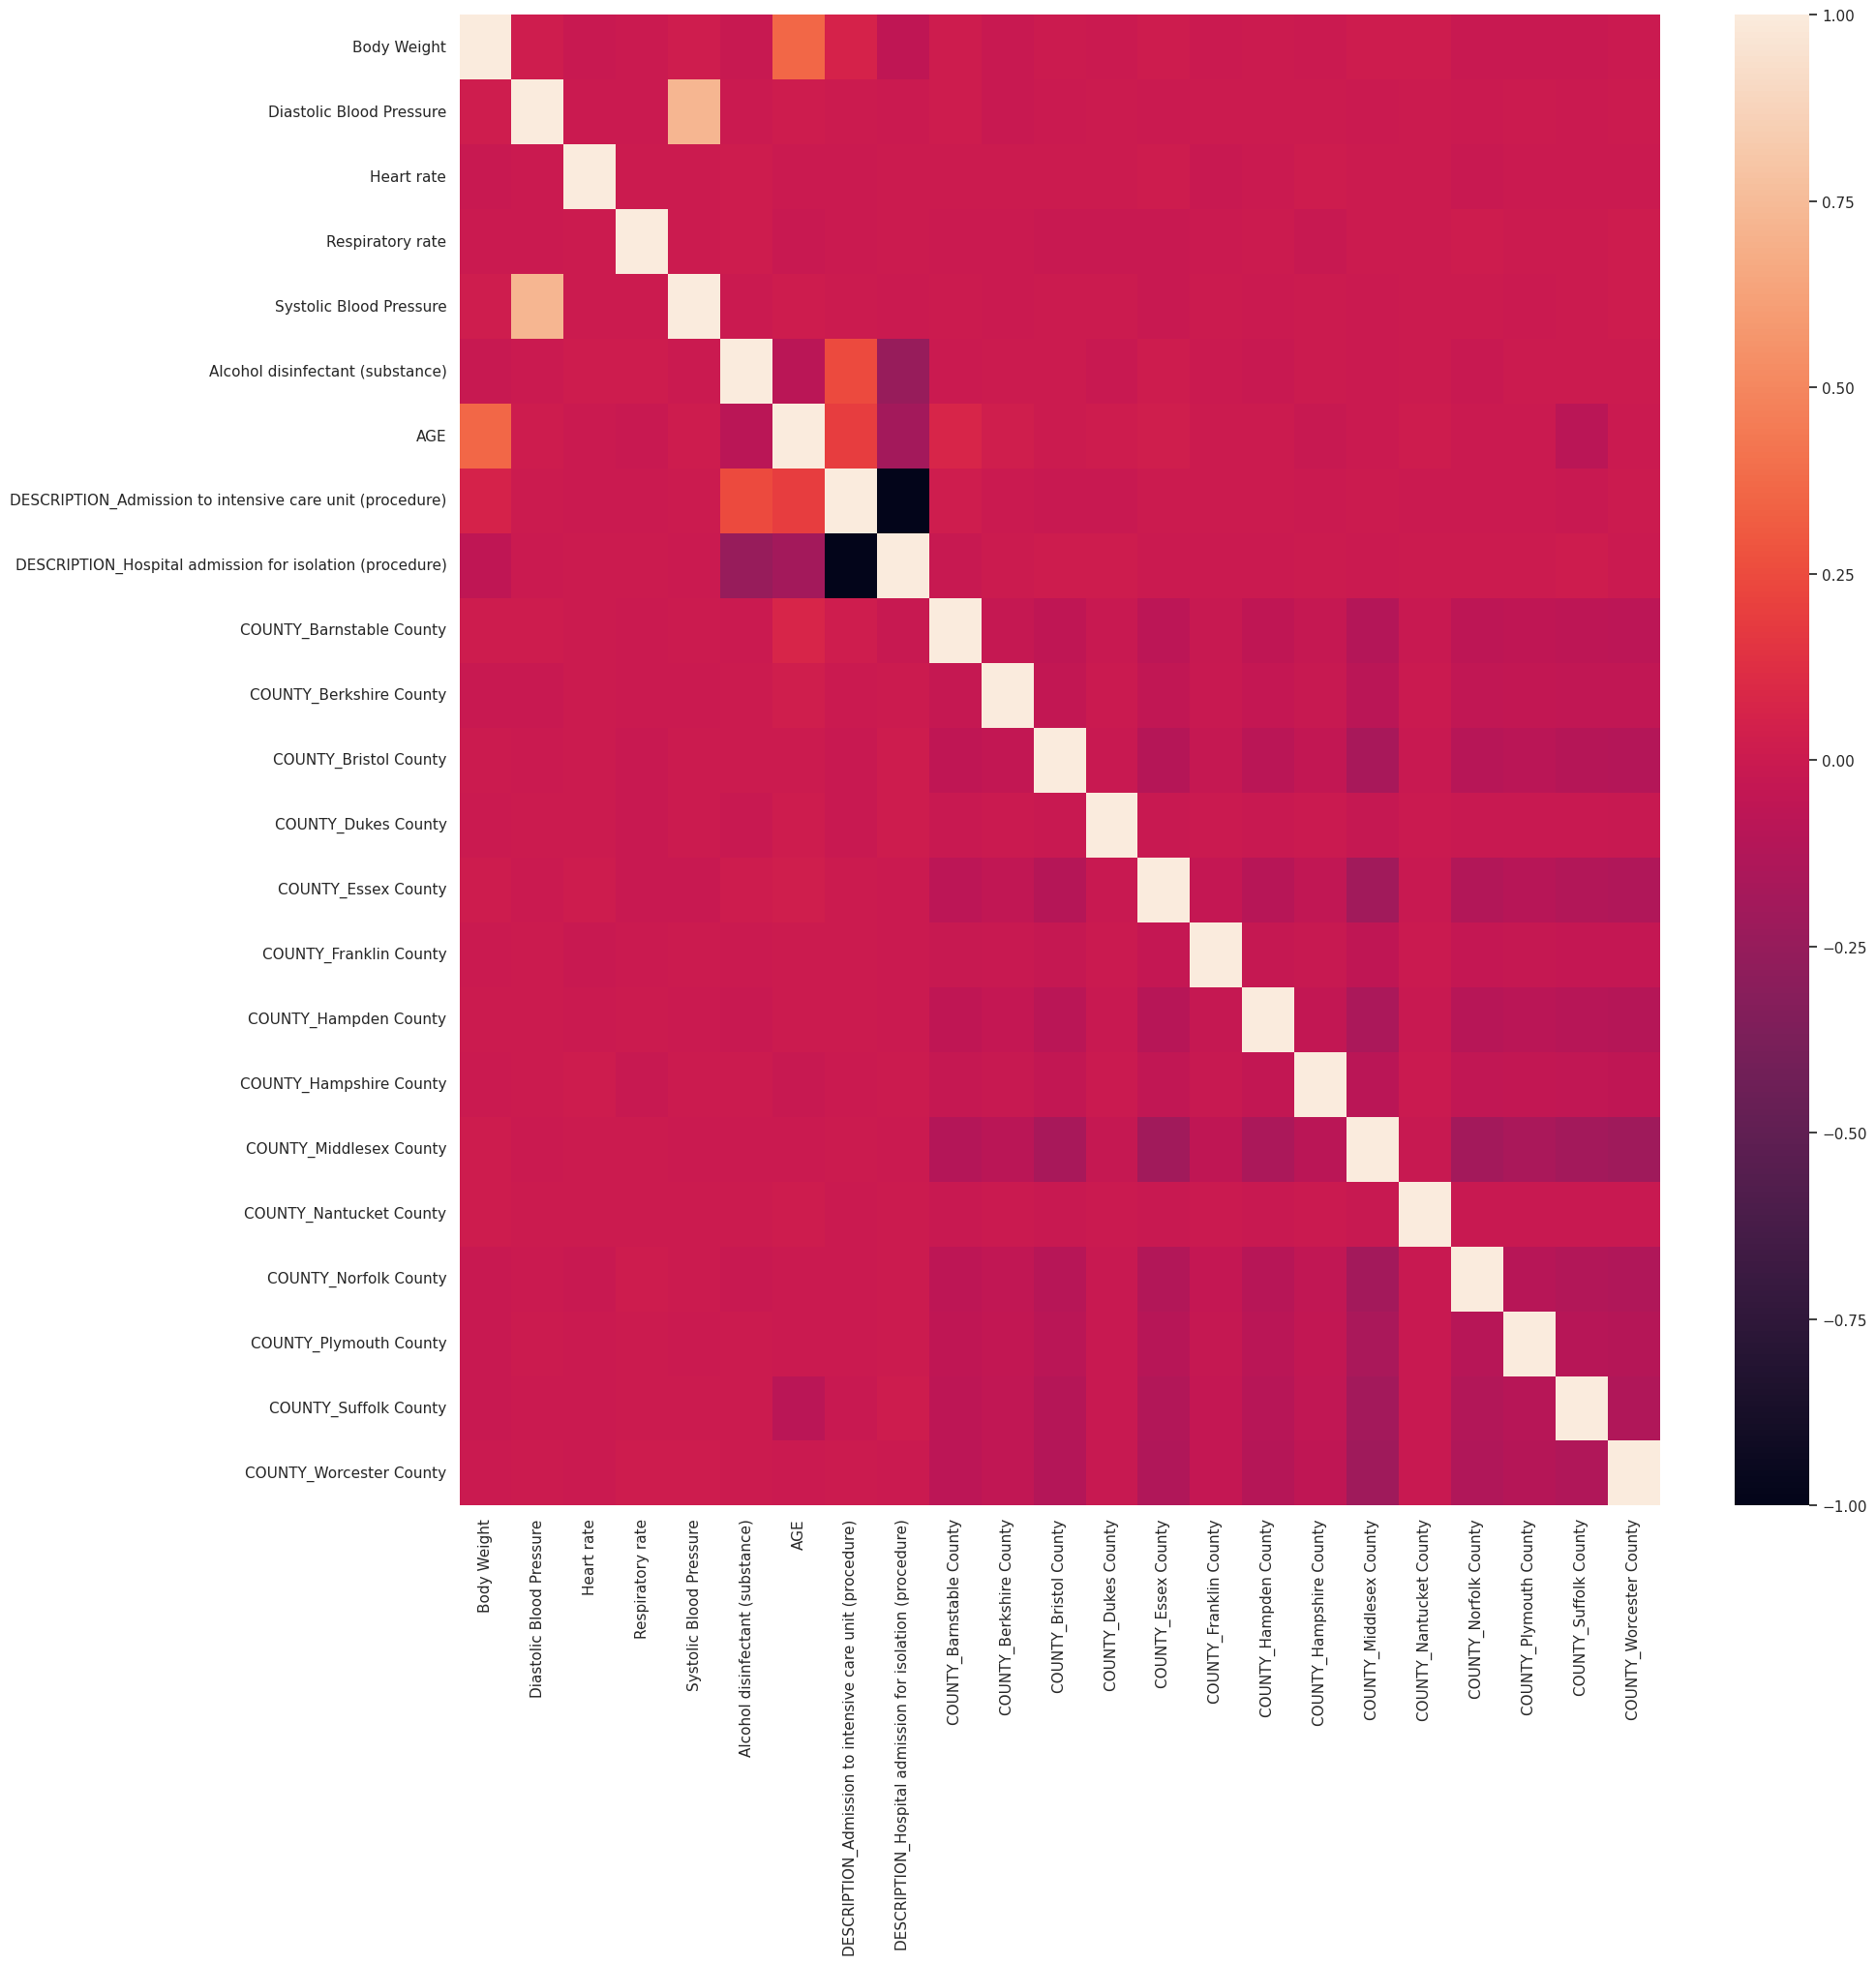

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sb.heatmap(alc_dis_df.corr() , annot=False, vmin=-1, vmax=1)

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = alc_dis_df.loc[:, ~alc_dis_df.columns.isin(['Alcohol disinfectant (substance)'])]
df_Y = alc_dis_df[['Alcohol disinfectant (substance)']]

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)
# y_train = np.asarray(y_train).reshape(-1)
# y_test = np.asarray(y_test).reshape(-1)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (17483, 22)
y_train.shape:  (17483, 1)
X_test.shape:  (4371, 22)
y_test.shape:  (4371, 1)


In [ ]:
# Standard scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# alc_dis_xgb = XGBRegressor(n_estimators=1000, eta=0.1, max_depth=2, colsample_bytree=0.6, random_state=42)

In [ ]:
# cv = RepeatedKFold(n_splits=10, random_state=42, n_repeats=1)
# rm_scores = np.abs(cross_val_score(alc_dis_xgb , df_X, df_Y, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=cv, verbose=1))

In [ ]:
# print("Model RMSE = ",rm_scores.mean())

In [ ]:
# param_grid = {
#     'n_estimators':[500,1000],
#     'eta':[0.1, 0.01],
#     'max_depth':[2], 
#     'colsample_bytree':[0.6, 0.8]
# }

In [ ]:
# alc_dis_gscv = GridSearchCV(estimator = alc_dis_xgb, param_grid = param_grid, cv = cv, verbose=1)

In [ ]:
# alc_dis_gscv.fit(X_train_std, y_train)

In [ ]:
# Fitting the model to scaled training data
xgb_reg.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Generating train and test predictions
alc_dis_train_preds = xgb_reg.predict(X_train_std)
alc_dis_test_preds = xgb_reg.predict(X_test_std)

In [ ]:
# Training and testing RMSE
print("Training RMSE = ",mean_squared_error(y_train, alc_dis_train_preds, squared=False))
print("Testing RMSE = ",mean_squared_error(y_test, alc_dis_test_preds, squared=False))

Training RMSE =  2.962095964257141
Testing RMSE =  3.063542725743019


In [ ]:
# best_xgbr = alc_dis_gscv.best_estimator_

In [ ]:
# Estimate of alcohol disinfectant 
np.median(alc_dis_test_preds)

10.7661495

### Antiseptic towelette (physical object)  


In [ ]:
# Focusing only on alcohol disinfectant
ant_tow_df = final_df.drop(columns=['Alcohol disinfectant (substance)', 'Disposable air-purifying respirator (physical object)', 'Face shield (physical object)', 'Isolation gown  single-use (physical object)', 'Nitrile examination/treatment glove  non-powdered  sterile (physical object)'])

<Axes: >

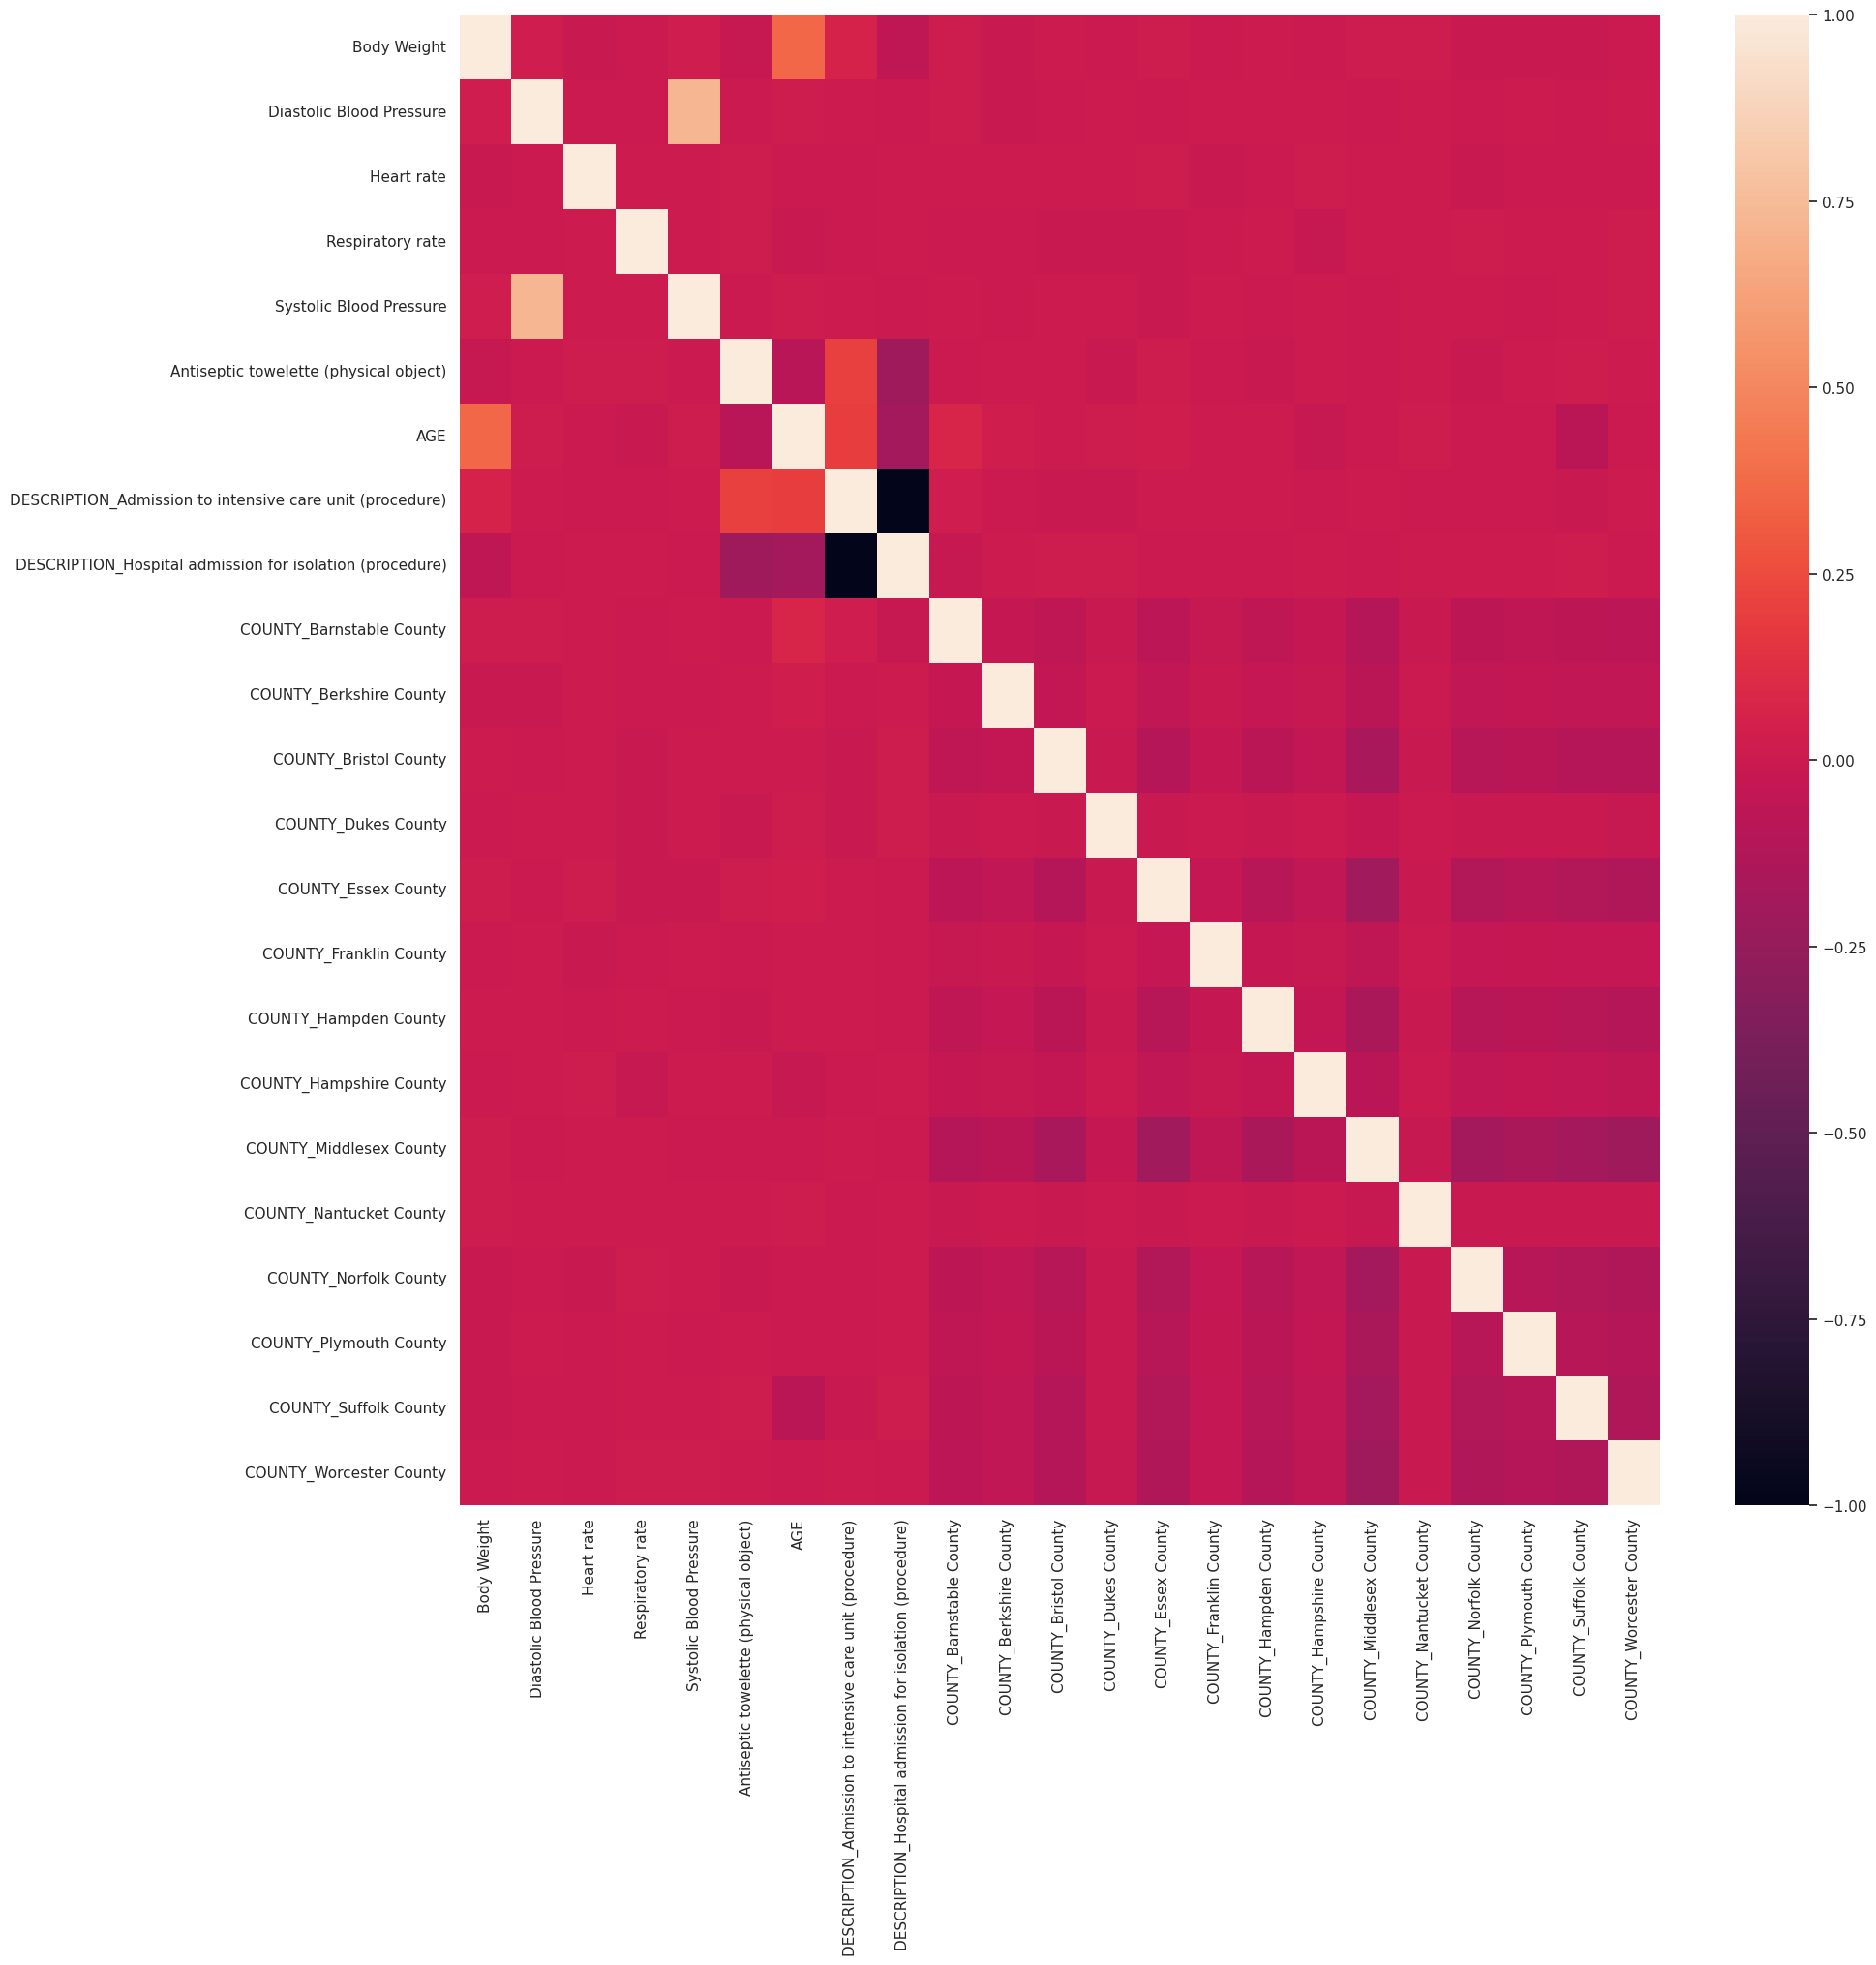

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sb.heatmap(ant_tow_df.corr() , annot=False, vmin=-1, vmax=1)

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = ant_tow_df.loc[:, ~ant_tow_df.columns.isin(['Antiseptic towelette (physical object)',])]
df_Y = ant_tow_df[['Antiseptic towelette (physical object)']]

In [ ]:
df_X.dtypes

Body Weight                                                 float64
Diastolic Blood Pressure                                    float64
Heart rate                                                  float64
Respiratory rate                                            float64
Systolic Blood Pressure                                     float64
AGE                                                           int64
DESCRIPTION_Admission to intensive care unit (procedure)      int64
DESCRIPTION_Hospital admission for isolation (procedure)      int64
COUNTY_Barnstable County                                      int64
COUNTY_Berkshire County                                       int64
COUNTY_Bristol County                                         int64
COUNTY_Dukes County                                           int64
COUNTY_Essex County                                           int64
COUNTY_Franklin County                                        int64
COUNTY_Hampden County                           

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)
# y_train = np.asarray(y_train).reshape(-1)
# y_test = np.asarray(y_test).reshape(-1)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (17483, 22)
y_train.shape:  (17483, 1)
X_test.shape:  (4371, 22)
y_test.shape:  (4371, 1)


In [ ]:
# Standard scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# ant_tow_xgb = XGBRegressor(n_estimators=1000, eta=0.1, max_depth=2, colsample_bytree=0.6, random_state=42)

In [ ]:
# cv = RepeatedKFold(n_splits=10, random_state=42, n_repeats=1)
# rm_scores = np.abs(cross_val_score(ant_tow_xgb , df_X, df_Y, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=cv, verbose=1))

In [ ]:
# print("Model RMSE = ",rm_scores.mean())

In [ ]:
# param_grid = {
#     'n_estimators':[500,1000],
#     'eta':[0.1, 0.01],
#     'max_depth':[2], 
#     'colsample_bytree':[0.6, 0.8]
# }

In [ ]:
# ant_tow_gscv = GridSearchCV(estimator = ant_tow_xgb, param_grid = param_grid, cv = cv, verbose=1)

In [ ]:
# ant_tow_gscv.fit(X_train, y_train)
# Fitting the model to scaled training data
xgb_reg.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Generating predictions on scaled training and testing data
ant_tow_train_preds = xgb_reg.predict(X_train_std)
ant_tow_test_preds = xgb_reg.predict(X_test_std)

In [ ]:
# Training and testing RMSE
print("Training RMSE = ",mean_squared_error(y_train, ant_tow_train_preds, squared=False))
print("Testing RMSE = ",mean_squared_error(y_test, ant_tow_test_preds, squared=False))

Training RMSE =  23.639804641282183
Testing RMSE =  24.454551126411715


In [ ]:
# Estimate of antiseptic towelettes
np.median(ant_tow_test_preds)

85.99027

### Disposable air-purifying respirator (physical object) 


In [ ]:
# focusing only on Disposable air-purifying respirator
disp_air_df = final_df.drop(columns=['Alcohol disinfectant (substance)', 'Antiseptic towelette (physical object)', 'Face shield (physical object)', 'Isolation gown  single-use (physical object)', 'Nitrile examination/treatment glove  non-powdered  sterile (physical object)'])

<Axes: >

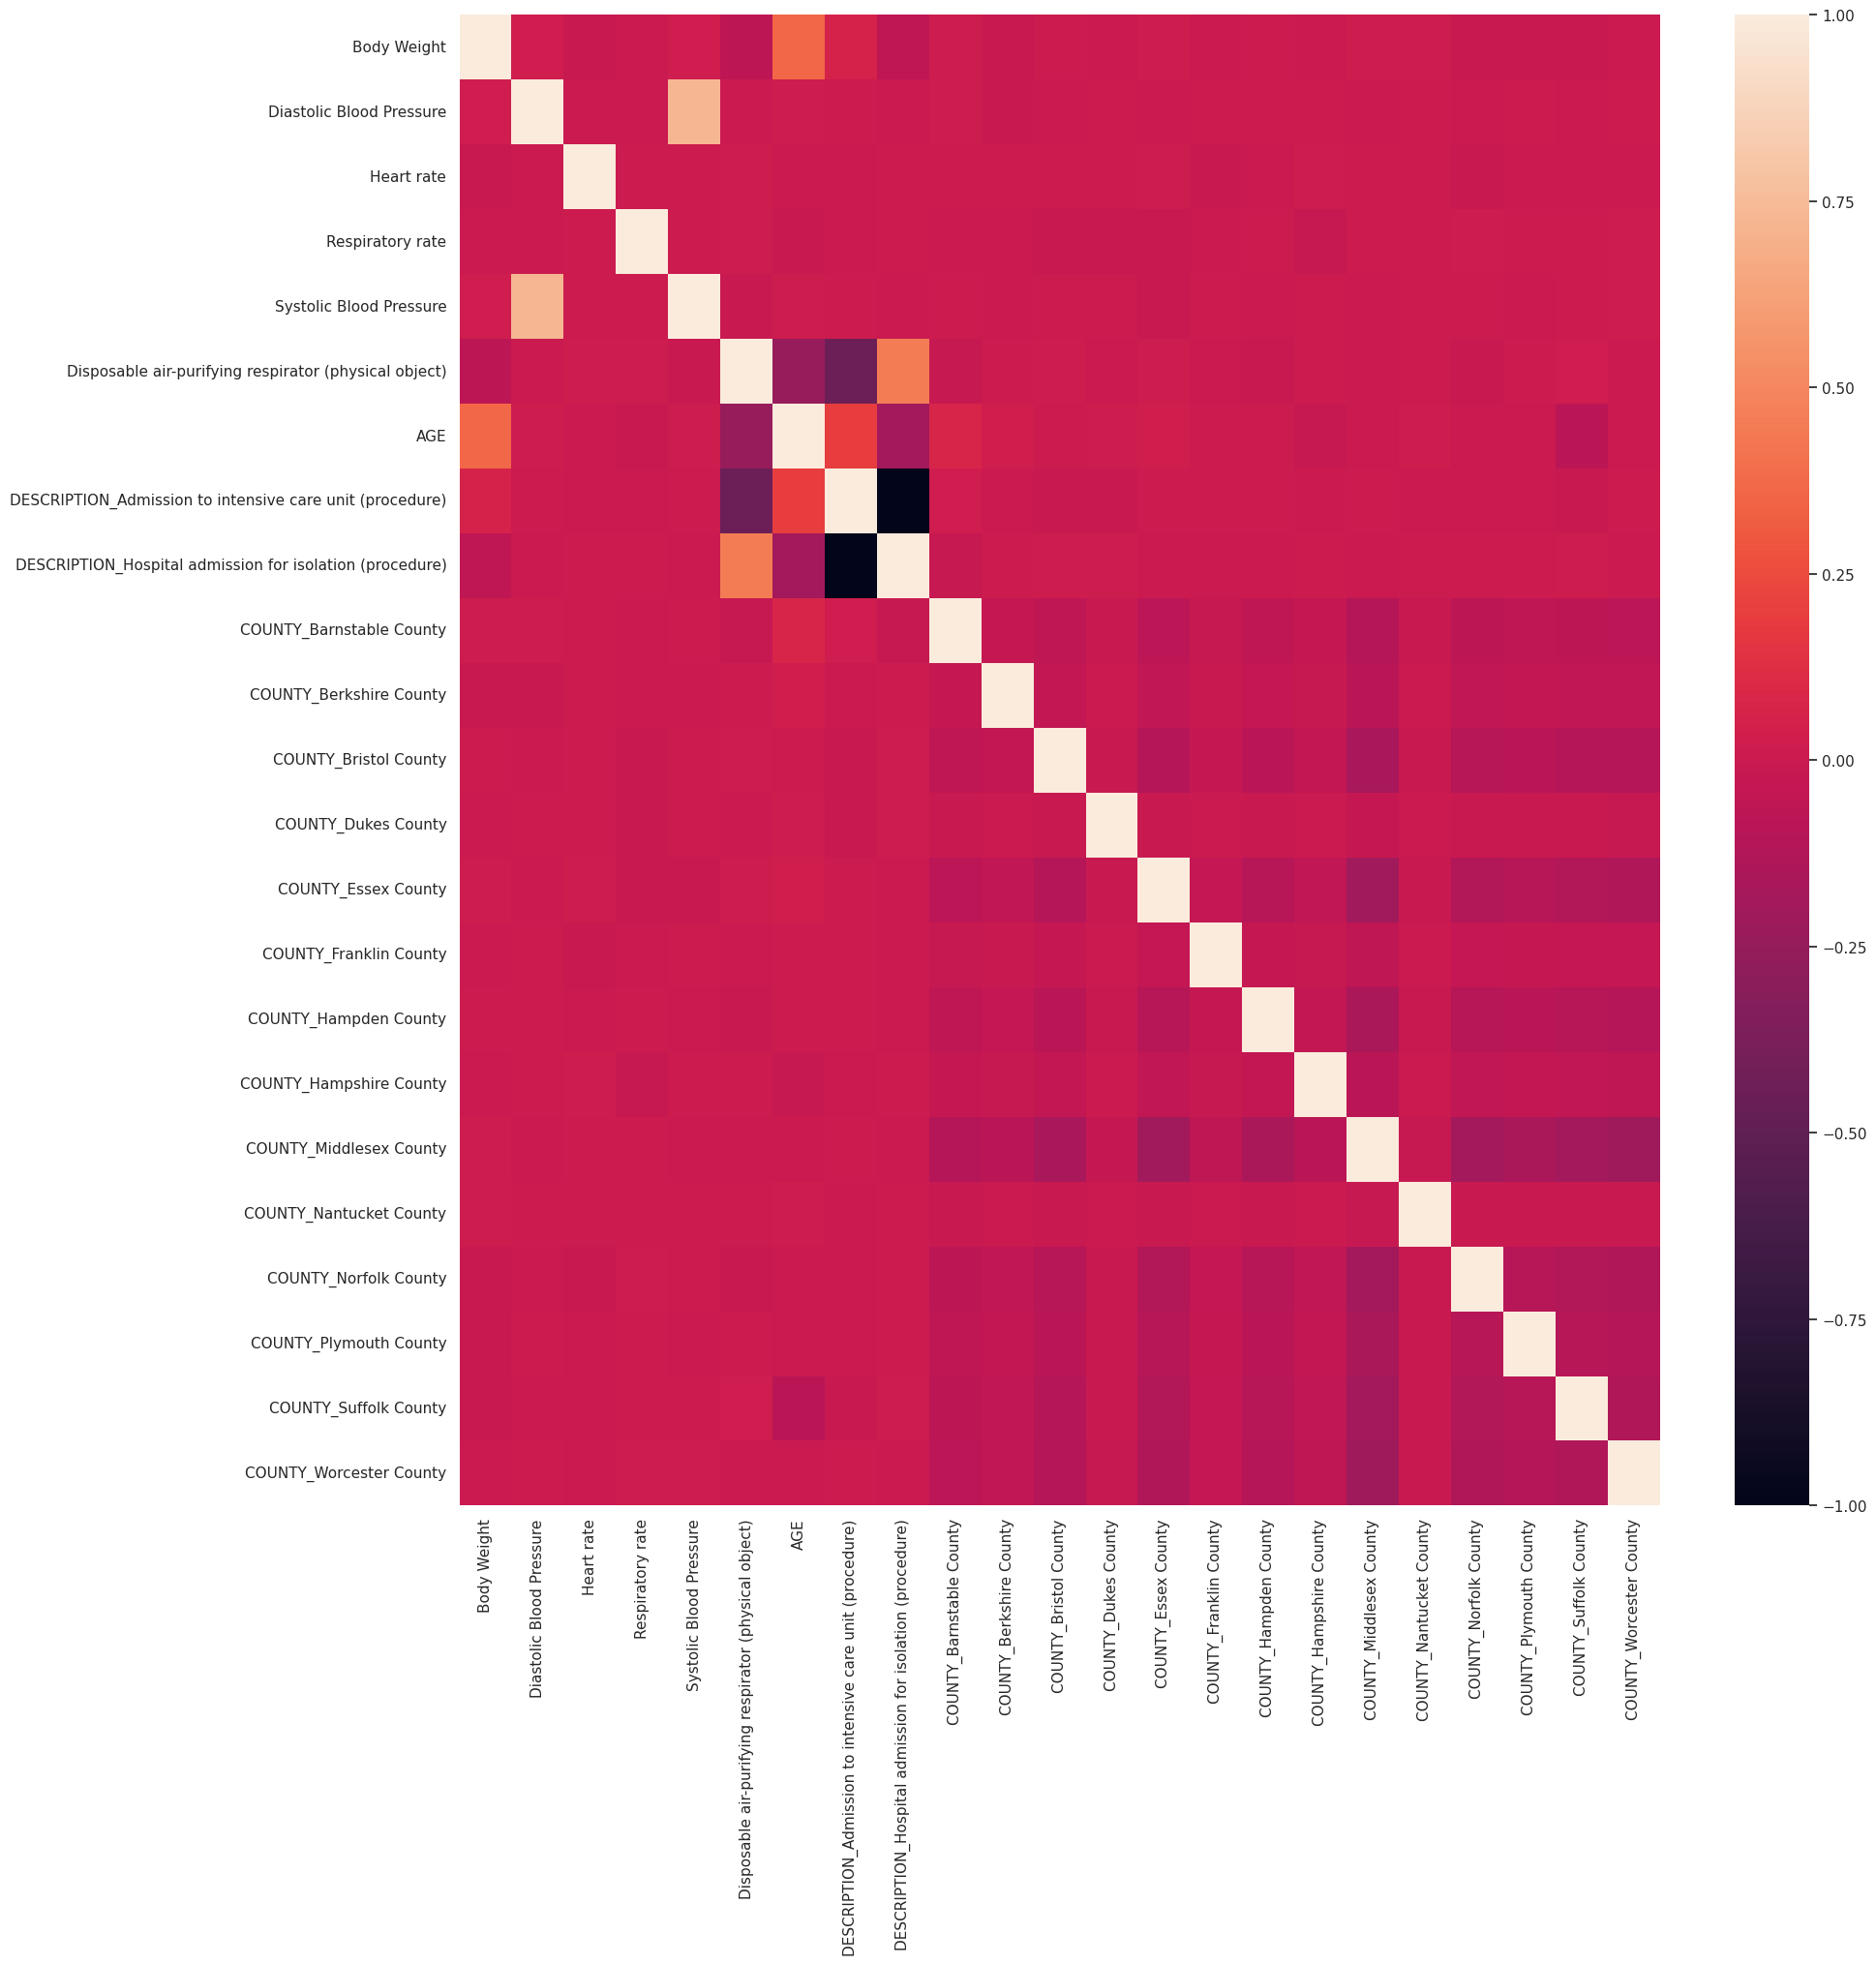

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sb.heatmap(disp_air_df.corr() , annot=False, vmin=-1, vmax=1)

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = disp_air_df.loc[:, ~disp_air_df.columns.isin(['Disposable air-purifying respirator (physical object)'])]
df_Y = disp_air_df[['Disposable air-purifying respirator (physical object)']]

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (17483, 22)
y_train.shape:  (17483,)
X_test.shape:  (4371, 22)
y_test.shape:  (4371,)


In [ ]:
# Standard scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# disp_air_xgb = XGBRegressor(n_estimators=1000, eta=0.1, max_depth=2, colsample_bytree=0.6, random_state=42)

In [ ]:
# cv = RepeatedKFold(n_splits=10, random_state=42, n_repeats=1)
# rm_scores = np.abs(cross_val_score(disp_air_xgb , df_X, df_Y, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=cv, verbose=1))

In [ ]:
# print("Model RMSE = ",rm_scores.mean())

In [ ]:
# param_grid = {
#     'n_estimators':[500,1000],
#     'eta':[0.1, 0.01],
#     'max_depth':[2], 
#     'colsample_bytree':[0.6, 0.8]
# }

In [ ]:
# disp_air_gscv = GridSearchCV(estimator = disp_air_xgb, param_grid = param_grid, cv = cv, verbose=1)

In [ ]:
# disp_air_gscv.fit(X_train, y_train)
# Fitting the model to scaled training data
xgb_reg.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Generating predictions from scaled training and testing data
disp_air_train_preds = xgb_reg.predict(X_train_std)
disp_air_test_preds = xgb_reg.predict(X_test_std)

In [ ]:
# Training and testing RMSE
print("Training RMSE = ",mean_squared_error(y_train, disp_air_train_preds, squared=False))
print("Testing RMSE = ",mean_squared_error(y_test, disp_air_test_preds, squared=False))

Training RMSE =  4.866679718199711
Testing RMSE =  5.077576186034907


In [ ]:
# Estimate of Disposable air-purifying respirator
np.median(disp_air_test_preds)

20.742226

### Face shield (physical object) 


In [ ]:
# focusing only on face shield
fa_sh_df = final_df.drop(columns=['Alcohol disinfectant (substance)', 'Antiseptic towelette (physical object)', 'Disposable air-purifying respirator (physical object)', 'Isolation gown  single-use (physical object)', 'Nitrile examination/treatment glove  non-powdered  sterile (physical object)'])

<Axes: >

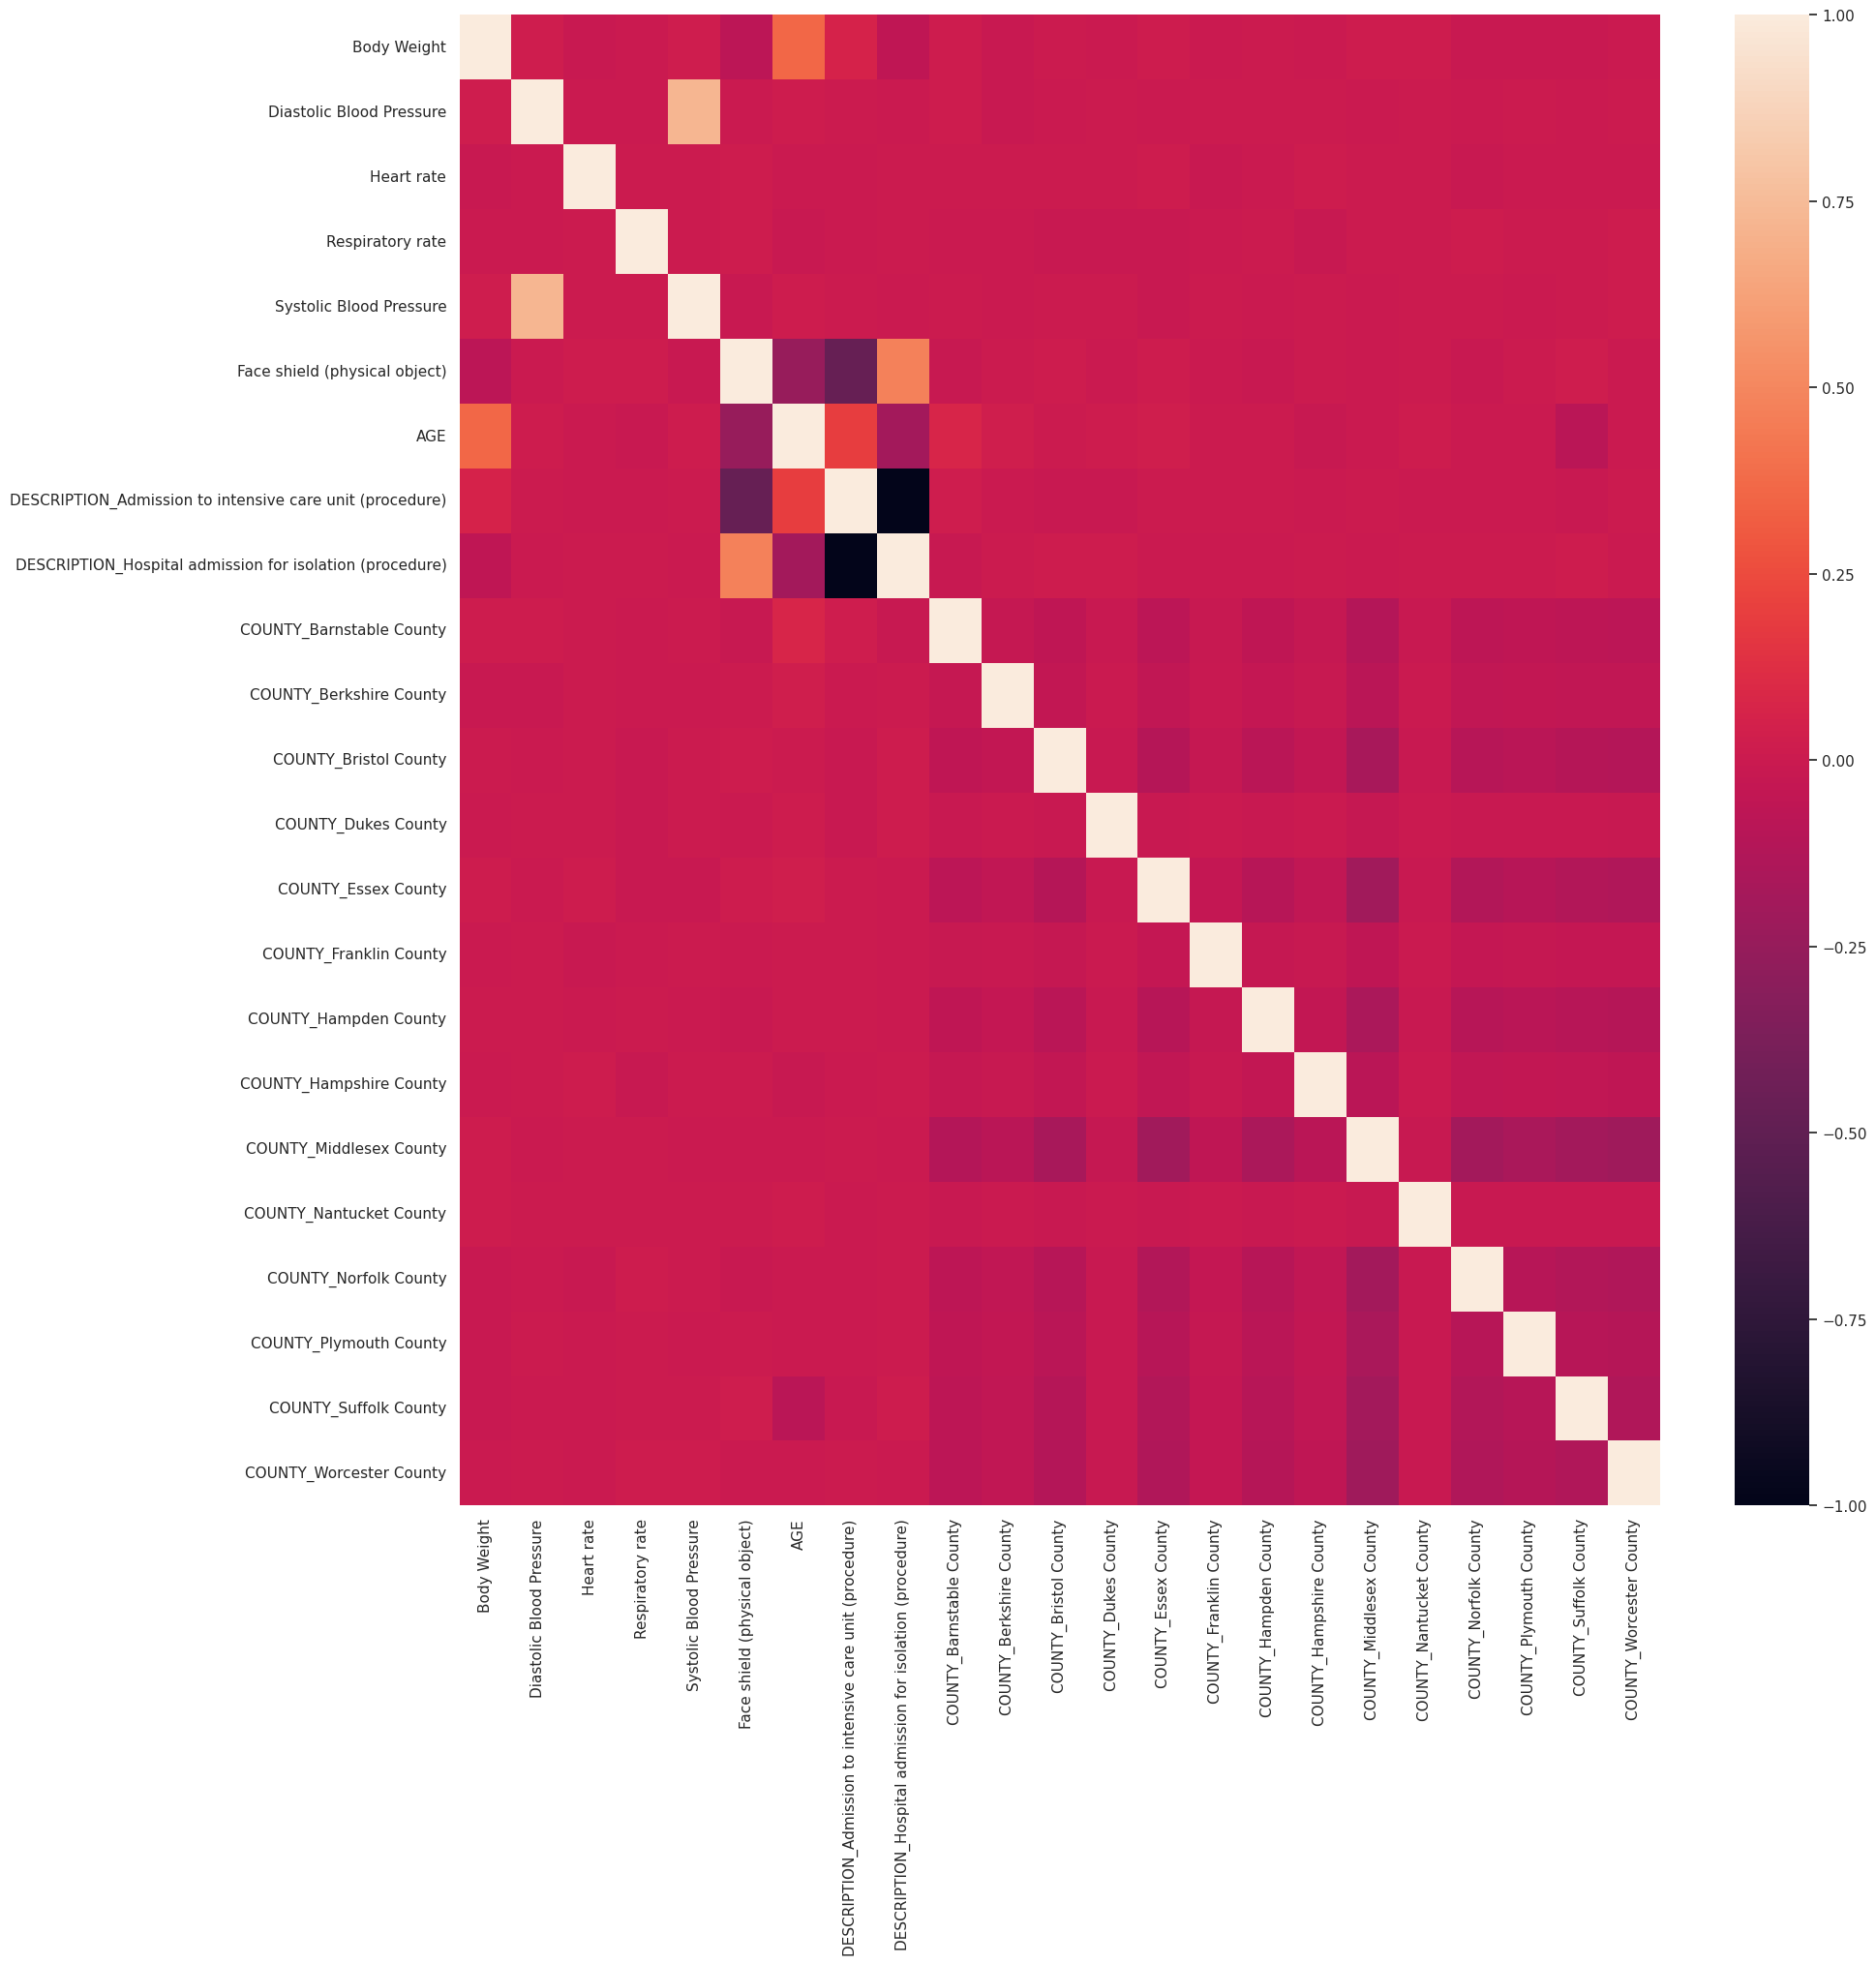

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sb.heatmap(fa_sh_df.corr() , annot=False, vmin=-1, vmax=1)

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = fa_sh_df.loc[:, ~fa_sh_df.columns.isin(['Face shield (physical object)'])]
df_Y = fa_sh_df[['Face shield (physical object)']]

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (17483, 22)
y_train.shape:  (17483,)
X_test.shape:  (4371, 22)
y_test.shape:  (4371,)


In [ ]:
# Standard scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# fa_sh_xgb = XGBRegressor(n_estimators=1000, eta=0.1, max_depth=2, colsample_bytree=0.6, random_state=42)

In [ ]:
# cv = RepeatedKFold(n_splits=10, random_state=42, n_repeats=1)
# rm_scores = np.abs(cross_val_score(fa_sh_xgb , df_X, df_Y, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=cv, verbose=1))

In [ ]:
# print("Model RMSE = ",rm_scores.mean())

In [ ]:
# param_grid = {
#     'n_estimators':[500,1000],
#     'eta':[0.1, 0.01],
#     'max_depth':[2], 
#     'colsample_bytree':[0.6, 0.8]
# }

In [ ]:
# fa_sh_gscv = GridSearchCV(estimator = fa_sh_xgb, param_grid = param_grid, cv = cv, verbose=1)

In [ ]:
# fa_sh_gscv.fit(X_train, y_train)
# Fitting the model on scaled train data
xgb_reg.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Generating model predictions on scaled train and test data
fa_sh_train_preds = xgb_reg.predict(X_train_std)
fa_sh_test_preds = xgb_reg.predict(X_test_std)

In [ ]:
# Training and testing RMSE
print("Training RMSE = ",mean_squared_error(y_train, fa_sh_train_preds, squared=False))
print("Testing RMSE = ",mean_squared_error(y_test, fa_sh_test_preds, squared=False))

Training RMSE =  4.858563014515588
Testing RMSE =  5.0695692204723


In [ ]:
# Estimate of face shield
np.median(fa_sh_test_preds)

20.74629

### Isolation gown  single-use (physical object)


In [ ]:
# focusing only on Isolation gown single-use
iso_gown_df = final_df.drop(columns=['Alcohol disinfectant (substance)', 'Antiseptic towelette (physical object)', 'Disposable air-purifying respirator (physical object)', 'Face shield (physical object)', 'Nitrile examination/treatment glove  non-powdered  sterile (physical object)'])

<Axes: >

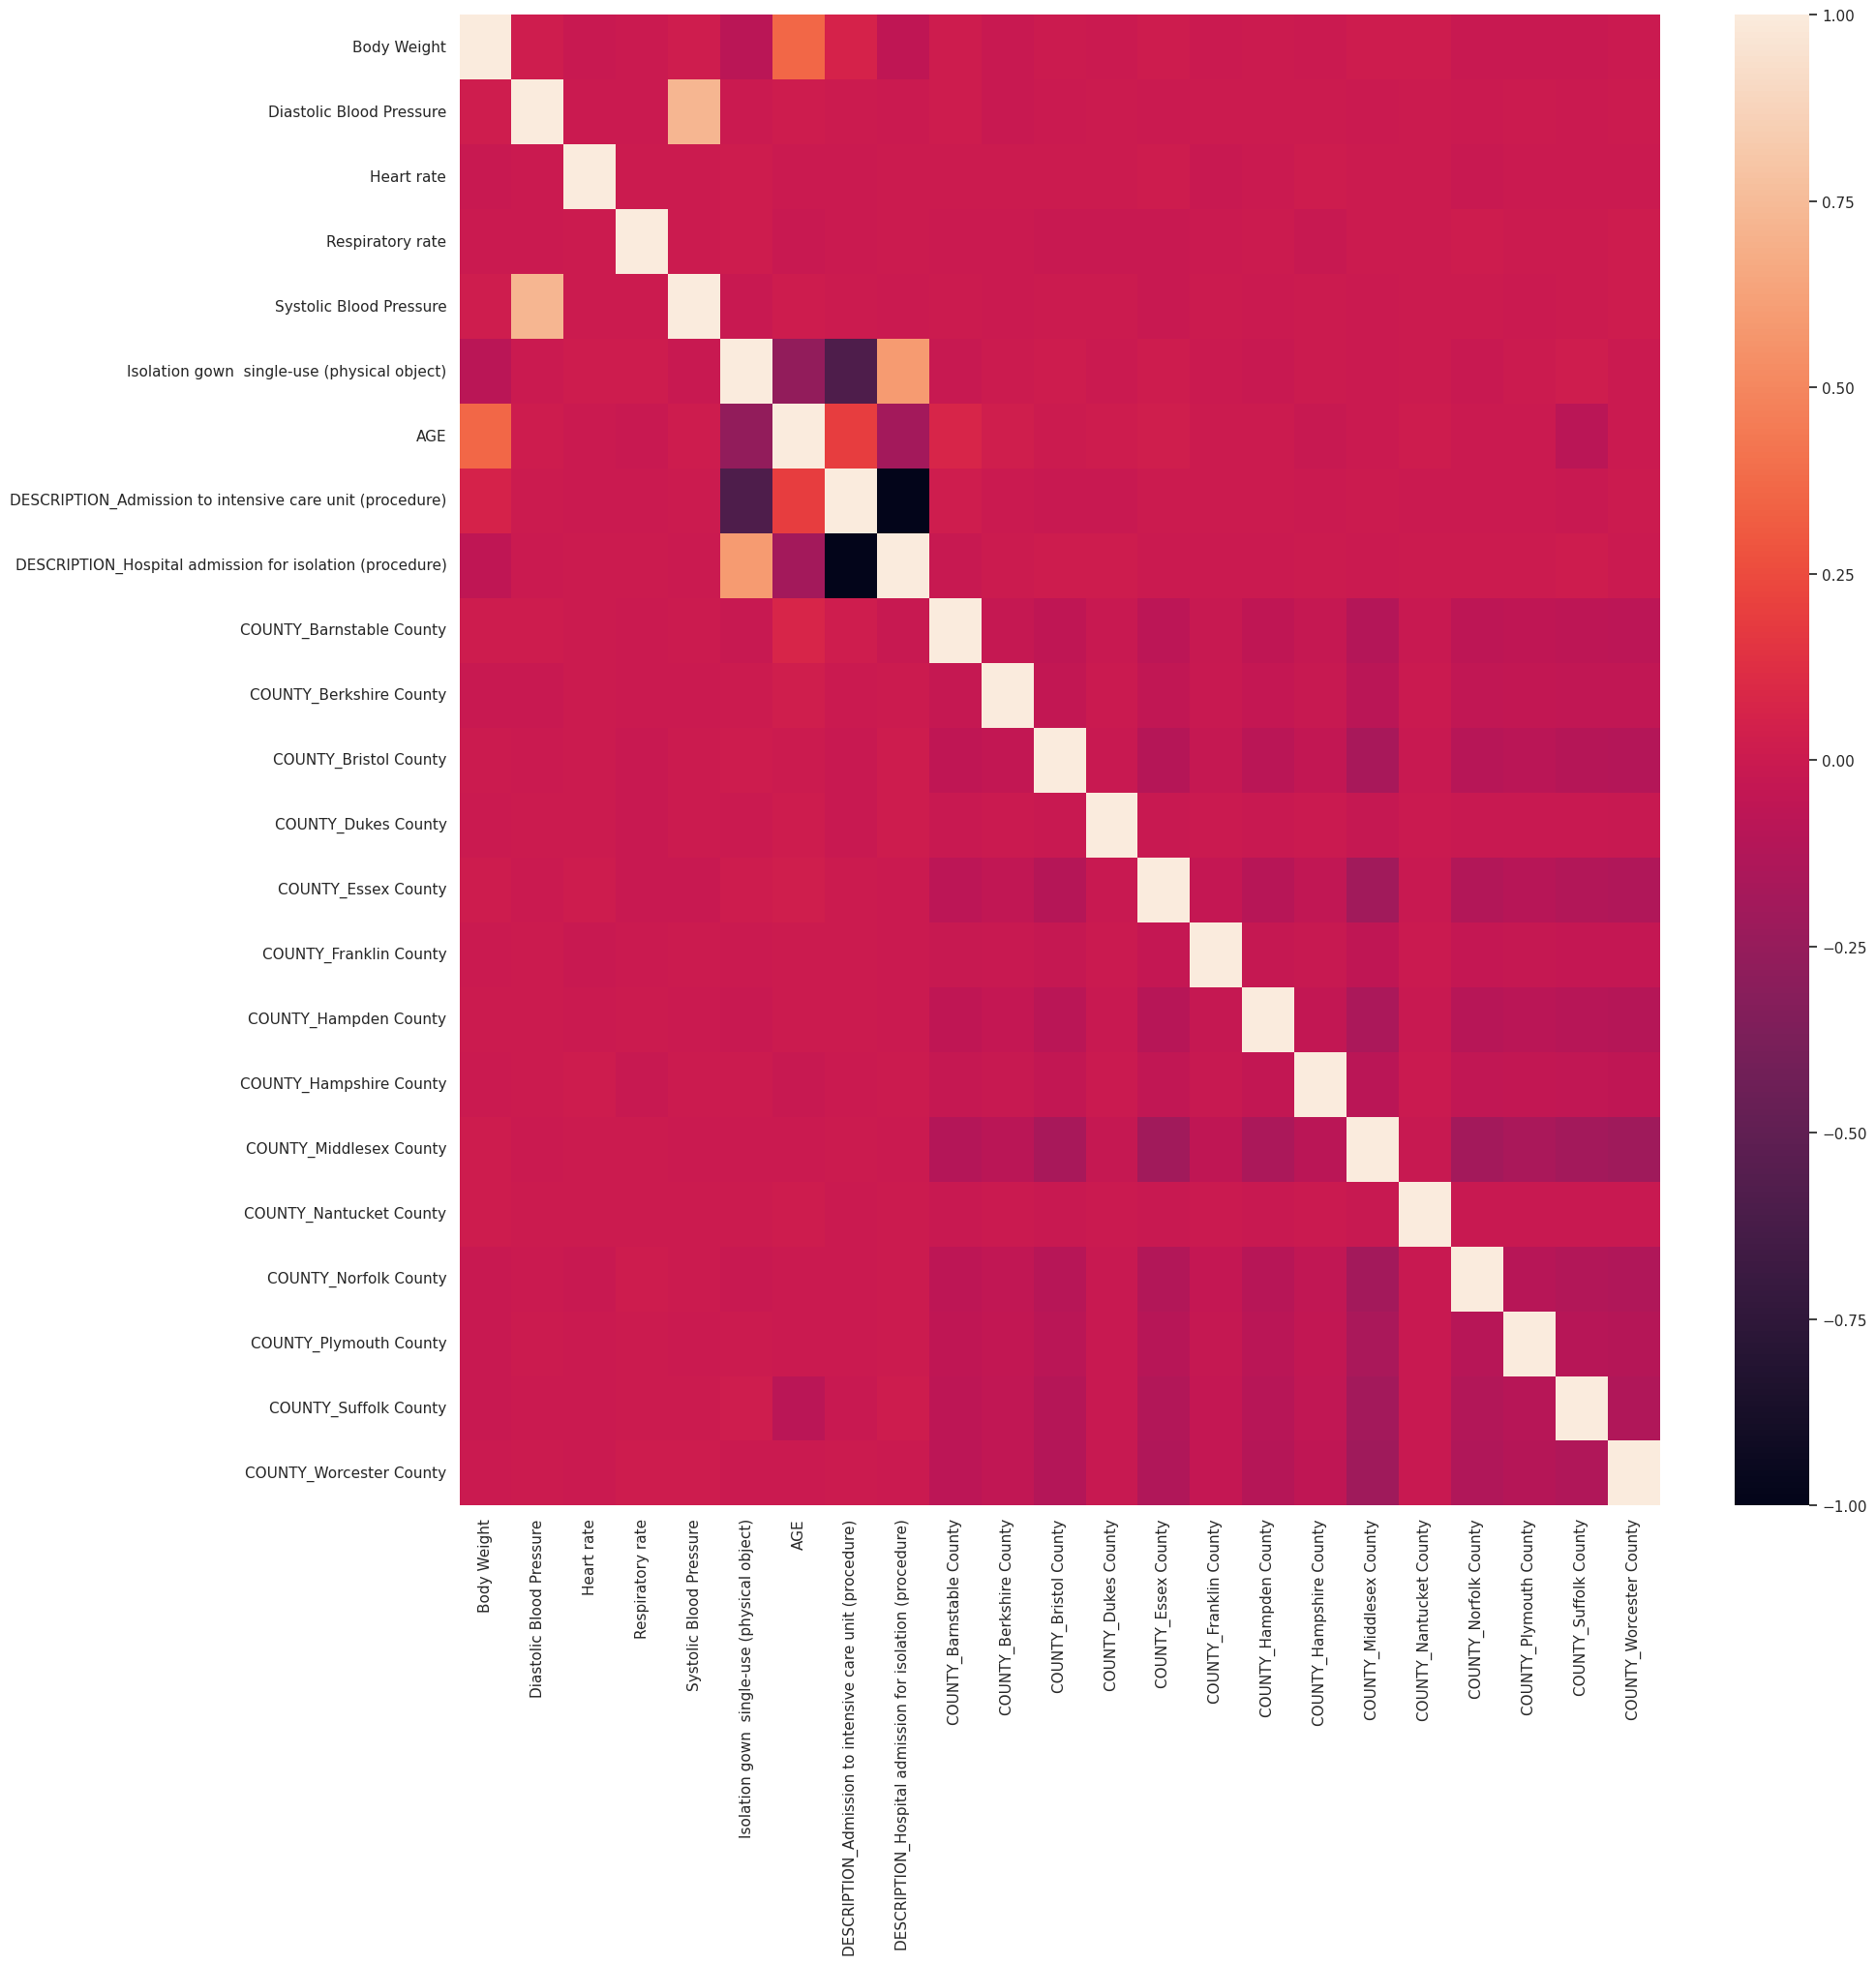

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sb.heatmap(iso_gown_df.corr() , annot=False, vmin=-1, vmax=1)

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = iso_gown_df.loc[:, ~iso_gown_df.columns.isin(['Isolation gown  single-use (physical object)'])]
df_Y = iso_gown_df[['Isolation gown  single-use (physical object)']]

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (17483, 22)
y_train.shape:  (17483,)
X_test.shape:  (4371, 22)
y_test.shape:  (4371,)


In [ ]:
# Scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# iso_gown_xgb = XGBRegressor(n_estimators=1000, eta=0.1, max_depth=2, colsample_bytree=0.6, random_state=42)

In [ ]:
# cv = RepeatedKFold(n_splits=10, random_state=42, n_repeats=1)
# rm_scores = np.abs(cross_val_score(iso_gown_xgb , df_X, df_Y, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=cv, verbose=1))

In [ ]:
# print("Model RMSE = ",rm_scores.mean())

In [ ]:
# param_grid = {
#     'n_estimators':[500,1000],
#     'eta':[0.1, 0.01],
#     'max_depth':[2], 
#     'colsample_bytree':[0.6, 0.8]
# }

In [ ]:
# iso_gown_gscv = GridSearchCV(estimator = iso_gown_xgb, param_grid = param_grid, cv = cv, verbose=1)

In [ ]:
# iso_gown_gscv.fit(X_train, y_train)
# Fitting the model on scaled training data
xgb_reg.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Generating predictions on scaled train and test data
iso_gown_train_preds = xgb_reg.predict(X_train_std)
iso_gown_test_preds = xgb_reg.predict(X_test_std)

In [ ]:
# training and testing RMSE
print("Training RMSE = ",mean_squared_error(y_train, iso_gown_train_preds, squared=False))
print("Testing RMSE = ",mean_squared_error(y_test, iso_gown_test_preds, squared=False))

Training RMSE =  28.34689391580573
Testing RMSE =  29.627729589164776


In [ ]:
# estimate of Isolation gown single-use
np.median(fa_sh_test_preds)

20.74629

### Nitrile examination/treatment glove  non-powdered  sterile (physical object)


In [ ]:
# focusing only on Nitrile examination/treatment glove non-powdered sterile (physical object)
glove_df = final_df.drop(columns=['Alcohol disinfectant (substance)', 'Antiseptic towelette (physical object)', 'Disposable air-purifying respirator (physical object)', 'Face shield (physical object)', 'Isolation gown  single-use (physical object)'])

<Axes: >

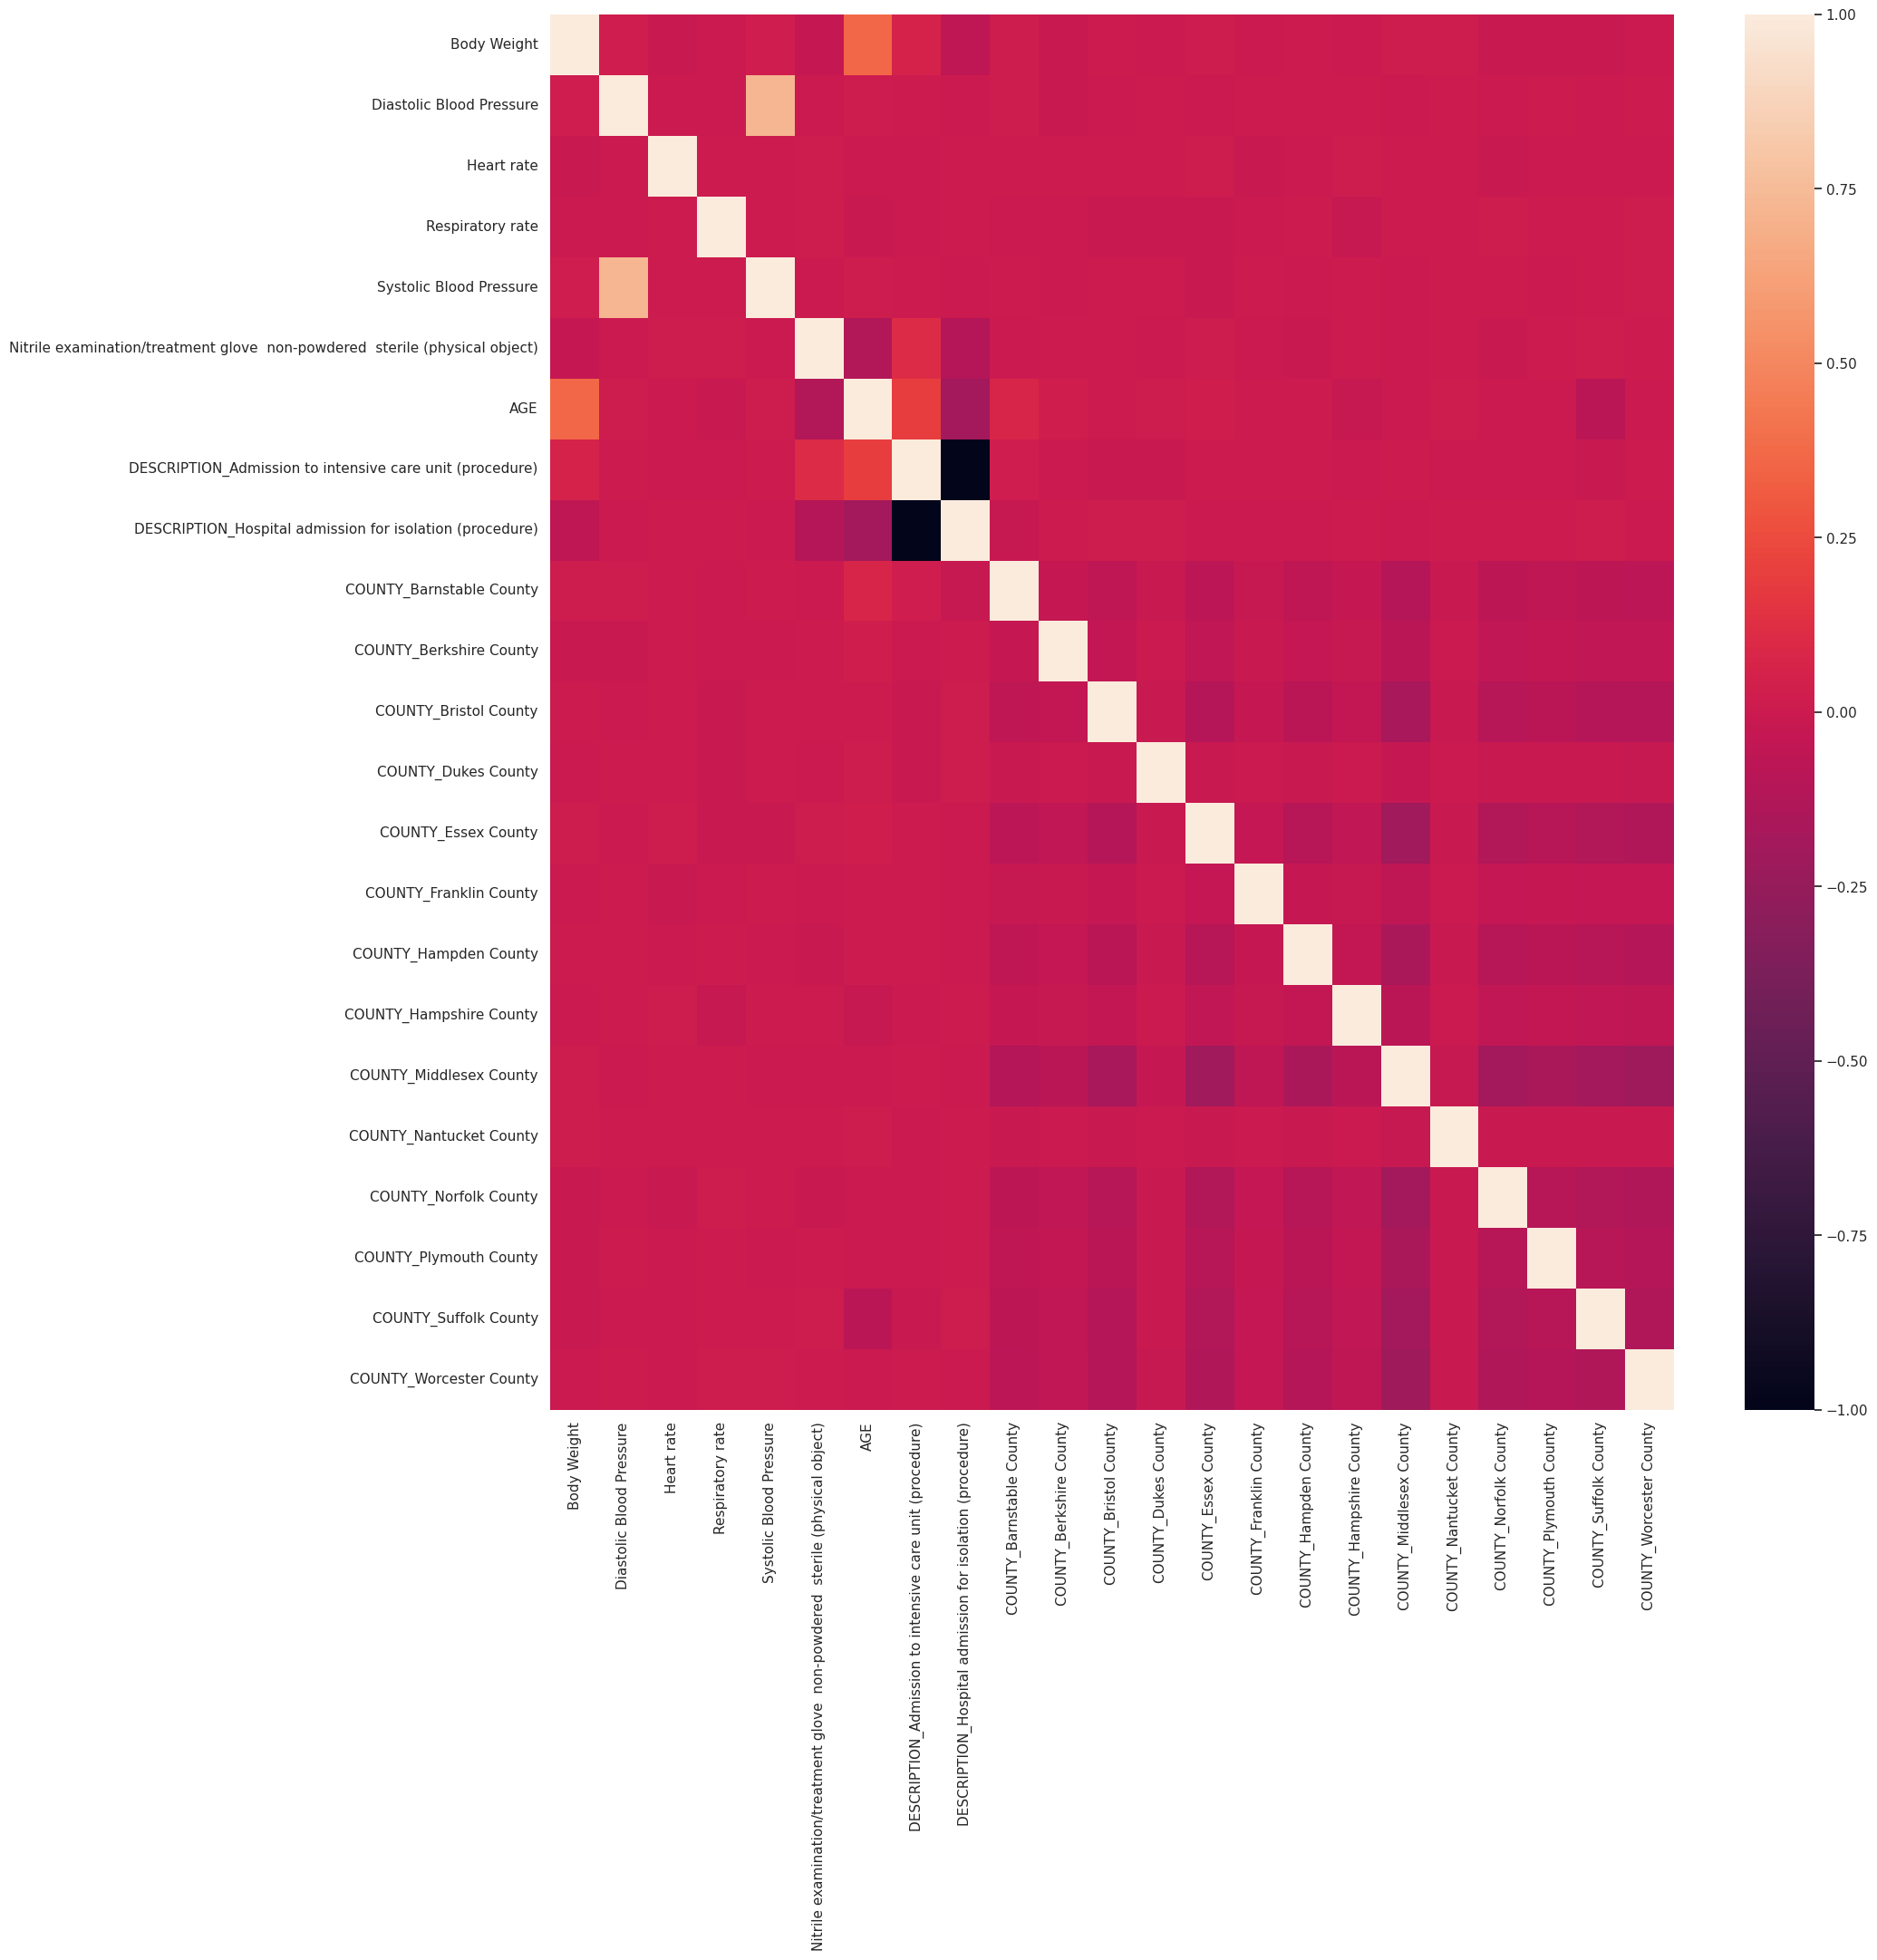

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sb.heatmap(glove_df.corr() , annot=False, vmin=-1, vmax=1)

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = glove_df.loc[:, ~glove_df.columns.isin(['Nitrile examination/treatment glove  non-powdered  sterile (physical object)'])]
df_Y = glove_df[['Nitrile examination/treatment glove  non-powdered  sterile (physical object)']]

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (17483, 22)
y_train.shape:  (17483,)
X_test.shape:  (4371, 22)
y_test.shape:  (4371,)


In [ ]:
# standard scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# glove_xgb = XGBRegressor(n_estimators=1000, eta=0.1, max_depth=2, colsample_bytree=0.6, random_state=42)

In [ ]:
# cv = RepeatedKFold(n_splits=10, random_state=42, n_repeats=1)
# rm_scores = np.abs(cross_val_score(glove_xgb , df_X, df_Y, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=cv, verbose=1))

In [ ]:
# print("Model RMSE = ",rm_scores.mean())

In [ ]:
# param_grid = {
#     'n_estimators':[500,1000],
#     'eta':[0.1, 0.01],
#     'max_depth':[2], 
#     'colsample_bytree':[0.6, 0.8]
# }

In [ ]:
# glove_gscv = GridSearchCV(estimator = glove_xgb, param_grid = param_grid, cv = cv, verbose=1)

In [ ]:
# glove_gscv.fit(X_train, y_train)
# Fitting the model on scaled training data
xgb_reg.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Generating predictions on scaled train and test data
glove_train_preds = xgb_reg.predict(X_train_std)
glove_test_preds = xgb_reg.predict(X_test_std)

In [ ]:
# Training and testing RMSE
print("Training RMSE = ",mean_squared_error(y_train, glove_train_preds, squared=False))
print("Testing RMSE = ",mean_squared_error(y_test, glove_test_preds, squared=False))

Training RMSE =  68.48903550815058
Testing RMSE =  70.89380595752024


In [ ]:
# Estimate of Nitrile examination/treatment glove non-powdered sterile (physical object)
np.median(glove_test_preds)

256.68024

Note: The code (below) for computing and plotting feature importance , SHAP values has been referenced from : https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-from-scikit-learn 

### Feature Importance and Explainability Analysis

In [ ]:
features_df = final_df.drop(columns=['Alcohol disinfectant (substance)', 'Antiseptic towelette (physical object)', 'Disposable air-purifying respirator (physical object)', 'Face shield (physical object)', 'Isolation gown  single-use (physical object)', 'Nitrile examination/treatment glove  non-powdered  sterile (physical object)'])

Text(0.5, 1.0, 'Feature Importance')

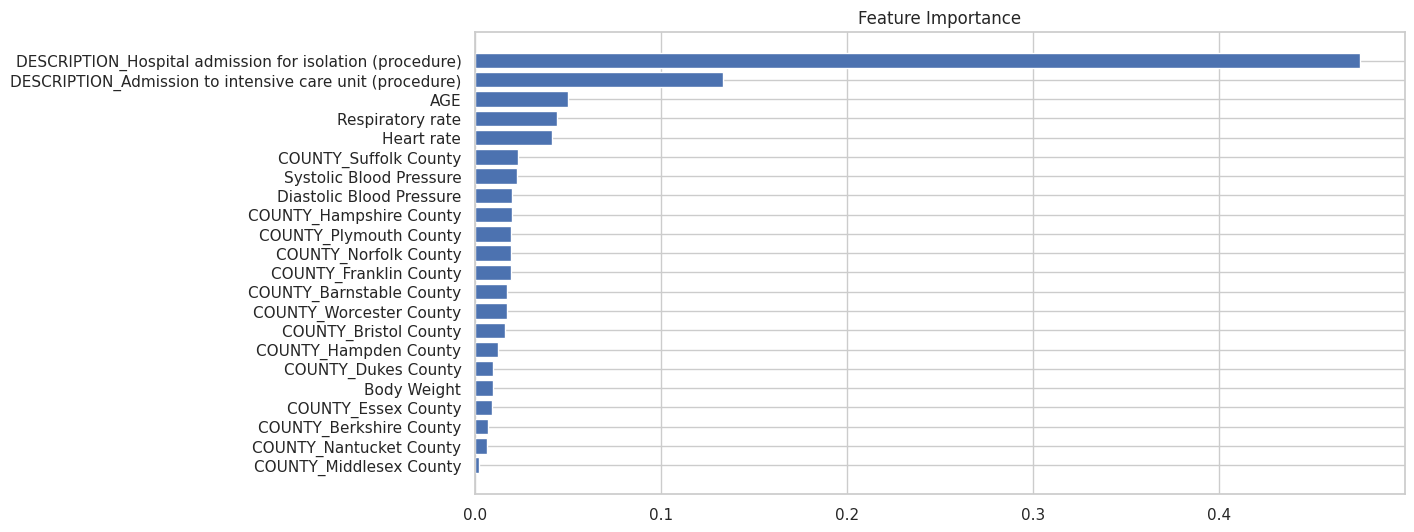

In [ ]:
feature_importance = xgb_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_df.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
np.sort(feature_importance[sorted_idx])

array([0.00246342, 0.00656595, 0.00711517, 0.00956377, 0.00964995,
       0.00976942, 0.01274193, 0.01626492, 0.01731861, 0.01751697,
       0.01949355, 0.01950913, 0.0195141 , 0.02022998, 0.02034378,
       0.02274776, 0.02356619, 0.04147688, 0.04436562, 0.05035363,
       0.13360877, 0.4758205 ], dtype=float32)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Text(0.5, 1.0, 'SHAP Importance')

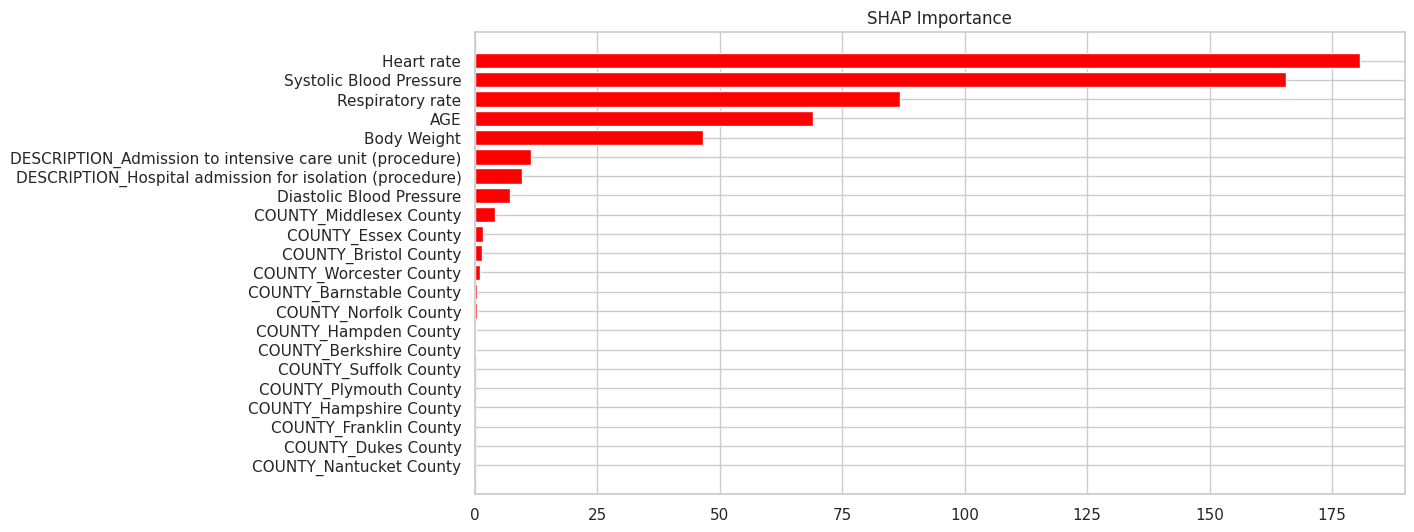

In [ ]:
explainer = shap.Explainer(xgb_reg)
shap_values = explainer(features_df)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center', color='red')
plt.yticks(range(len(sorted_idx)), np.array(features_df.columns)[sorted_idx])
plt.title('SHAP Importance')

In [ ]:
np.sort(shap_importance)

array([2.4796233e-03, 5.6142185e-02, 8.2770556e-02, 1.4501831e-01,
       1.5822013e-01, 1.8810475e-01, 2.4557036e-01, 3.1456956e-01,
       4.0234545e-01, 4.2132768e-01, 1.1762484e+00, 1.5346860e+00,
       1.7677646e+00, 4.1235609e+00, 7.2199826e+00, 9.7211351e+00,
       1.1527706e+01, 4.6669956e+01, 6.8967865e+01, 8.6894905e+01,
       1.6566780e+02, 1.8074039e+02], dtype=float32)